# From notebook netoyage

In [1]:
### 0.1 Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
import seaborn as sns
import time

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import f_oneway, levene, bartlett

!pip install researchpy
from scipy import stats
import researchpy as rp

### 0.2 Functions

def nan_volumetry(df):
    """
    Plot a barh graph of NaN percentage values of every columns
    
    """
    n = len(df)
    m = n*(1/4)
    percentage_nan={}
    for i in df.columns:
        x = df[i].isna().sum()
        percentage = (x/n)*100
        percentage_nan[i] = percentage
        
    a = percentage_nan.keys()
    b = percentage_nan.values()
    percentage = pd.DataFrame({'columns':a,'%_NaN':b})
    percentage.sort_values('%_NaN', inplace=True)
    
    #PLOT

    plt.rcParams["figure.figsize"] =(10,len(percentage)/3)
    plt.figure()
    plt.title('NaN Percentage',fontsize=40, pad=40)
    plt.ylabel('Columns',fontsize = 20)
    plt.xlabel('% NaN', fontsize = 20)
    plt.barh(percentage['columns'],percentage['%_NaN'], label = percentage,color = 'r') 
    plt.margins(0.001)
    plt.grid(axis = 'x',linewidth=2, color = 'black')
    plt.xlim([0,100])
    plt.tick_params( length =15, labelsize=15)
    
    val = list(round(percentage['%_NaN'],4))
    for i in range(len(val)):
        plt.text(1/3,i-0.25,str(val[i])+'%', fontsize=15, color = 'black' )
    plt.savefig('NanVal',pad_inches=200, bbox_inches='tight')    
    plt.show()
    plt.close()

def check_size(df):
    
    """Check len of Data Frame"""
    
    print('CHECK SIZE OF DATAFRAME')
    print('number of elements : '+str(len(df)))

def drop_data_macronutrients_range(data,maximum_threshold=110,minimum_threshold=90):
    x = data.drop(index = ((data.loc[data.loc[:,macronutrients].sum(axis = 1) < minimum_threshold])).index)
    x.drop(index = ((x.loc[x.loc[:,macronutrients].sum(axis = 1) > maximum_threshold])).index , inplace=True )
    check_size(x)
    return x

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
   
            fig = plt.figure(figsize=(12,12))
        
            # points display
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend(bbox_to_anchor=(1, .5), loc = 'center left')

            # labels' points display
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # graph limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # abscissa and ordinate lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # axis' names, with explained percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} and F{})".format(d1+1, d2+1))
            plt.show(block=False)

def data_describe_mean_median(data_dictionary,data_zero):
    """
    input: dictionary with the modified DataFrames and the origina DataFrame 
    
    The function 

    """
    data_describe_mean={}
    data_describe_median={}
    for key, values in data_dictionary.items():
        data_describe_mean[key] = pd.DataFrame(((data_zero.describe())-(values.describe())).loc['mean']).rename(columns={'mean':key}).transpose()
        data_describe_median[key] = pd.DataFrame(((data_zero.describe())-(values.describe())).loc['50%']).rename(columns={'50%':key}).transpose()

    data_describe_mean= pd.concat(data_describe_mean.values())
    data_describe_median = pd.concat(data_describe_median.values())

    print('data_describe_mean')
    display(data_describe_mean)

    std_scaler = preprocessing.StandardScaler().fit(data_describe_mean)
    data_describe_mean_scaled = std_scaler.transform(data_describe_mean)
    data_describe_mean_scaled_abs = pd.DataFrame(data_describe_mean_scaled, index=data_dictionary.keys(),columns=quantitative_features).abs()

    print('data_describe_mean_scaled_abs')
    display(data_describe_mean_scaled_abs)

    print('data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1)')
    display(data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1))

    print('data_describe_median')
    display(data_describe_median)

    std_scaler = preprocessing.StandardScaler().fit(data_describe_median)
    data_describe_median_scaled = std_scaler.transform(data_describe_median)
    data_describe_median_scaled_abs = pd.DataFrame(data_describe_median_scaled, index=data_dictionary.keys(), columns=quantitative_features).abs()

    print('data_describe_median_scaled_abs')
    display(data_describe_median_scaled_abs)

    print('data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1)')
    display(data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1))


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # we display the 3 first factorial plane, i.e. the first 6 composants

        if d2 < n_comp:

            fig, ax = plt.subplots(figsize=(7,6))

            # graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # display arrows
            # do not show if more than 30
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # display variables names  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # plot cicle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # graphic lim
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # abscissa and ordinate lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # axis' names, with explained percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Circle of correlation (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        


#I will need to see all the columns
pd.set_option('display.max_columns', None)


index = ['code','product_name', 'generic_name']

macronutrients = ['fat_100g', 
                  'carbohydrates_100g', 
                  'fiber_100g', 
                  'proteins_100g', 
                  'salt_100g']
energy_macronutrients = ['energy_100g',
                         'fat_100g',
                         'carbohydrates_100g', 
                         'fiber_100g', 
                         'proteins_100g', 
                         'salt_100g']
quantitative_features = ['energy_100g', 
                         'fat_100g', 
                         'saturated-fat_100g', 
                         'cholesterol_100g', 
                         'carbohydrates_100g', 
                         'sugars_100g', 
                         'fiber_100g', 
                         'proteins_100g', 
                         'salt_100g']
qualitative_features = ['code',
                        'product_name', 
                        'generic_name', 
                        'pnns_groups_1', 
                        'pnns_groups_2']
quantitative_features_100 = ['fat_100g',
                             'saturated-fat_100g',
                             'cholesterol_100g',
                             'carbohydrates_100g',
                             'sugars_100g',
                             'fiber_100g',
                             'proteins_100g',
                             'salt_100g']
features = qualitative_features + quantitative_features


data_simp_imp_droped = pd.read_csv('data_simp_imp_droped.csv' )
data_ite_imp_droped = pd.read_csv('data_ite_imp_droped.csv' )
data_knn_X_droped = pd.read_csv('data_knn_X_droped.csv' )
data_knn_X_scaled_droped = pd.read_csv('data_knn_X_scaled_droped.csv' )

simp_imp = pd.read_csv('simp_imp.csv' )
ite_imp = pd.read_csv('ite_imp.csv' )
knn_X = pd.read_csv('knn_X.csv' )
knn_X_scaled = pd.read_csv('knn_X_scaled.csv' )

data_old = pd.read_csv('data_old.csv')
data_droped = pd.read_csv('data_droped.csv')

data = data_simp_imp_droped 
data_pnns = data.dropna(subset = ['pnns_groups_1','pnns_groups_2'])

C:\Users\emanu\AppData\Local\Temp\ipykernel_5784\2932894863.py:266: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_old = pd.read_csv('data_old.csv')


# Contents

### 5. Univariate analysis
    5.1 Category features
        5.1.1 Distribution of pnns groups 1 (pie)
        5.1.2 Distribution of pnns groups 2 (pie)
    5.2 Numerical features
        5.2.1 Pnns distribution (boxplot)
        5.2.2 Qualitative features distribution (displot & histplot)
        5.2.3 Anova pnns_groups_1
        5.2.4 Anova pnns_groups_2
    
### 6. Bivariante analysis
    6.1 Category features
        6.1.1 Distribution of pnns groups 1 & 2 (pie)
    6.2 Numerical features
        6.2.1 Correlation
        6.2.2 Distribution (pairplot)

### 7. Multivariate analysis
    7.1 ACP
        7.1.1 Centering, scaled, pca
        7.1.2 Scree plot
        7.1.3 Circle of correlation
        7.1.4 Factorial planes
    7.2 ANOVA
        








## 5. Univariate analysis

### 5.1 Category features

#### 5.1.1 Distribution of pnns group 1

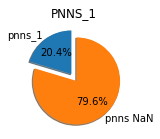

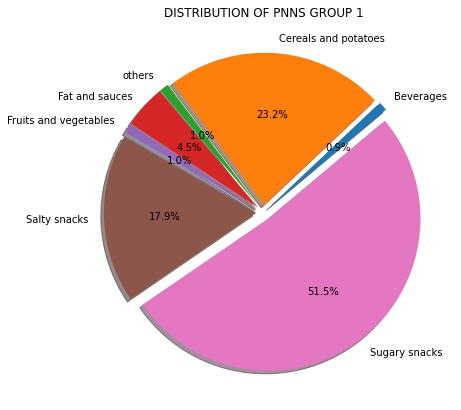

In [2]:
pnns1_num = data['pnns_groups_1'].notna().sum()
pnns_nan_num = data['pnns_groups_1'].isna().sum()

labels = ['pnns_1', 'pnns NaN']
sizes = [pnns1_num, pnns_nan_num]
explode = (.1,.1)

fig = plt.figure(figsize=(2,2))
plt.title('PNNS_1')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

labels = []
sizes = []
others = 0
for i in data['pnns_groups_1'].sort_values().drop_duplicates().tolist():
    j = len(data.loc[data['pnns_groups_1']==i])
    if j > 100:
        sizes.append(len(data.loc[data['pnns_groups_1']==i]))
        labels.append(i)
    else:
        others += j
labels.insert(2,'others')
sizes.insert(2, others)

explode = [0.05 for i in sizes]
fig = plt.figure(figsize=(7,7))
plt.title('DISTRIBUTION OF PNNS GROUP 1')
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=40)
plt.show()

#### 5.1.2 Distribution of pnns group 2

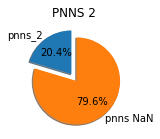

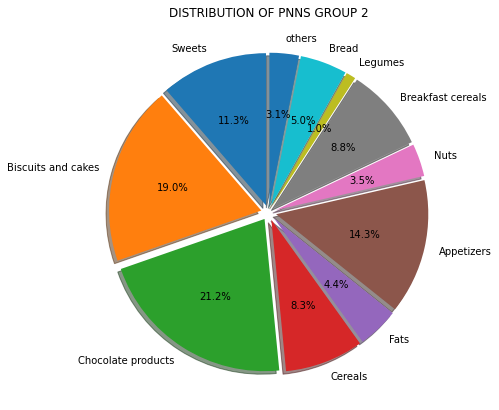

In [3]:
pnns2_num = data['pnns_groups_2'].notna().sum()
pnns_nan_num = data['pnns_groups_2'].isna().sum()

labels = ['pnns_2', 'pnns NaN']
sizes = [pnns2_num, pnns_nan_num]
explode = (.1,.1)

fig = plt.figure(figsize=(2,2))
plt.title('PNNS 2')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

labels = []
sizes = []
others = 0
for i in data['pnns_groups_2'].drop_duplicates().tolist():
    j = len(data.loc[data['pnns_groups_2']==i])
    if j > 100:
        sizes.append(len(data.loc[data['pnns_groups_2']==i]))
        labels.append(i)
    else:
        others += j
labels.append('others')
sizes.append(others)

explode = [0.05 for i in sizes]
fig = plt.figure(figsize=(7,7))
plt.title('DISTRIBUTION OF PNNS GROUP 2')
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

### 5.2  Numerical features

#### 5.2.1 Pnns distribution

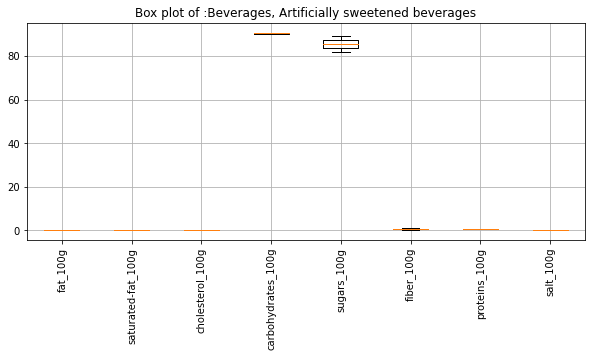

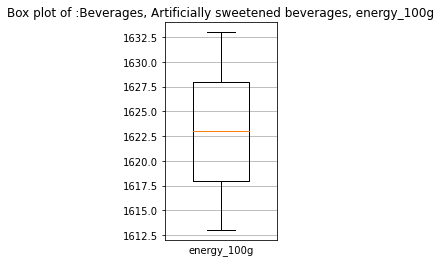

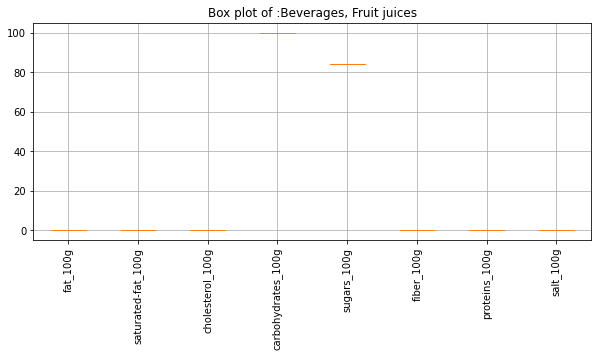

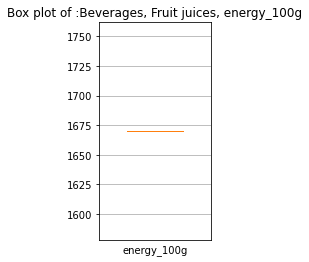

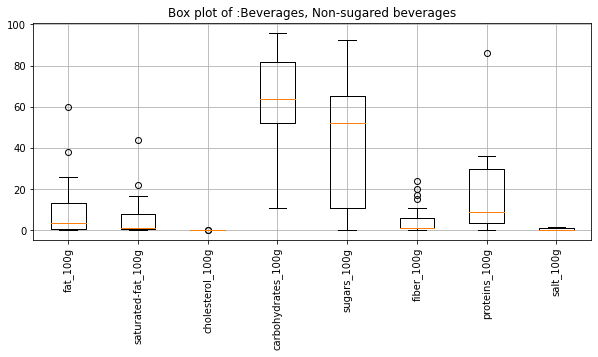

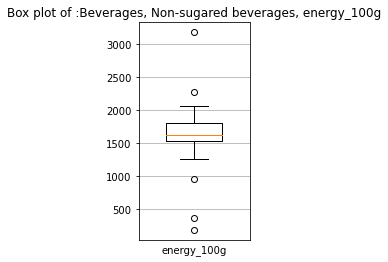

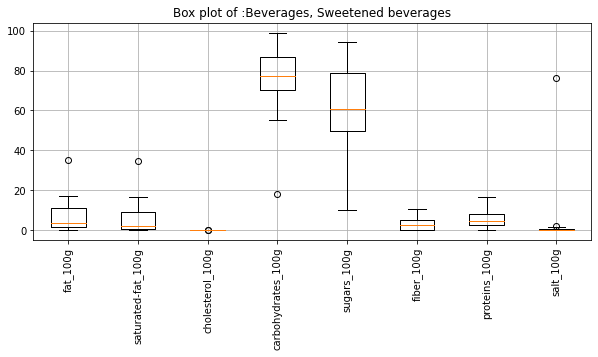

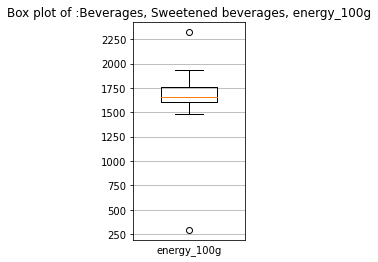

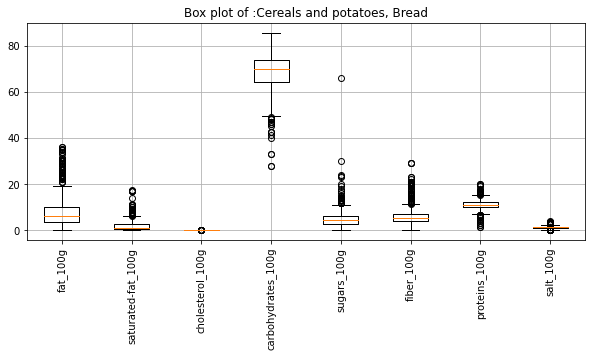

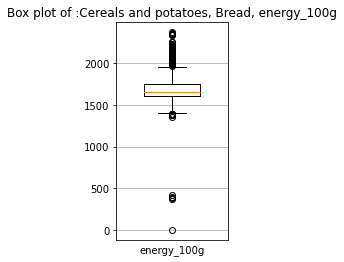

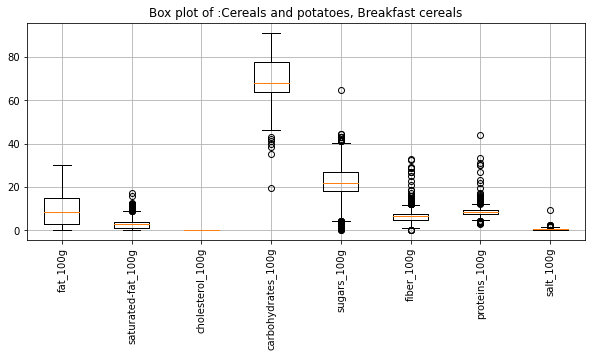

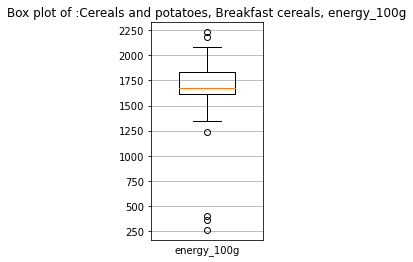

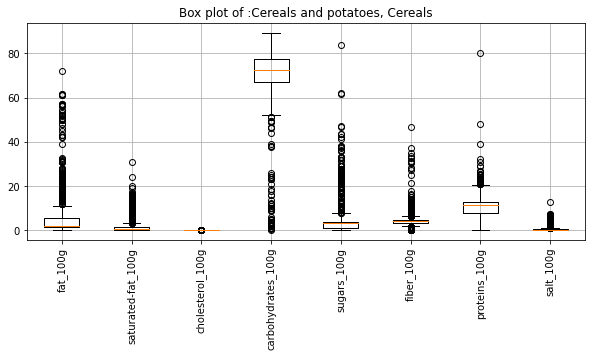

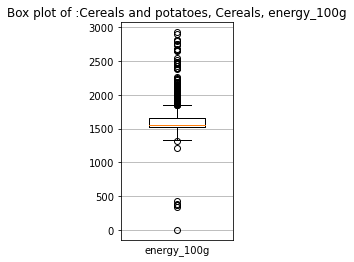

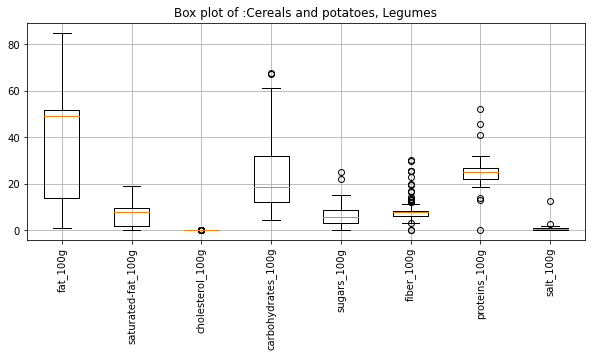

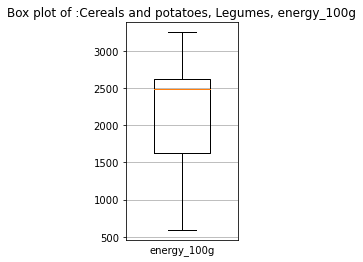

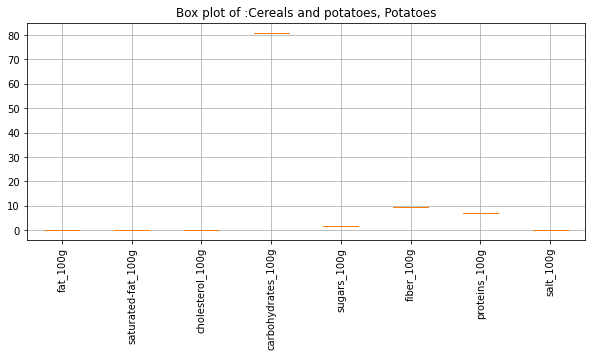

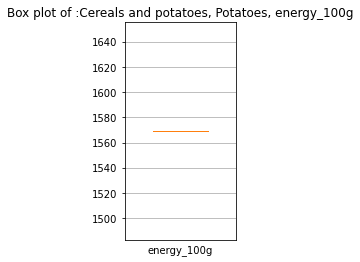

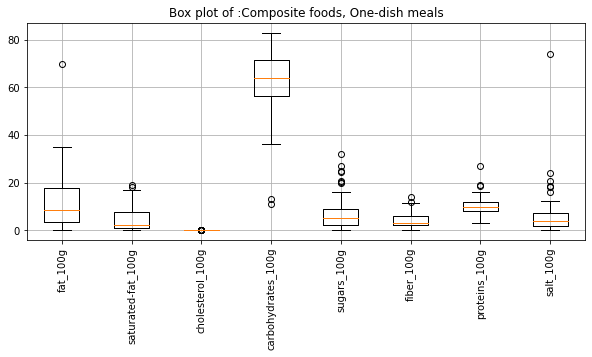

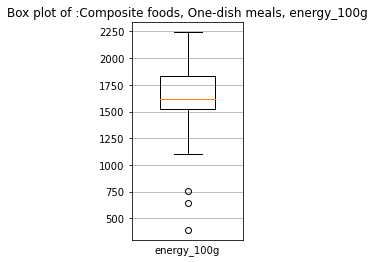

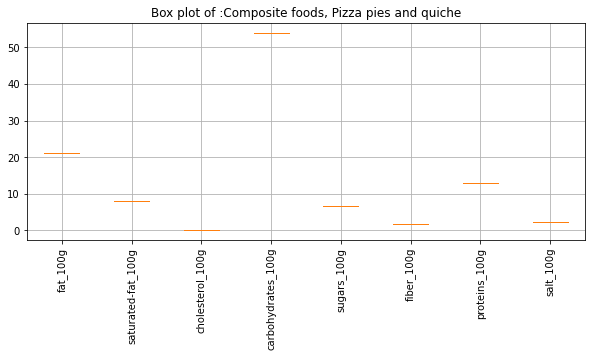

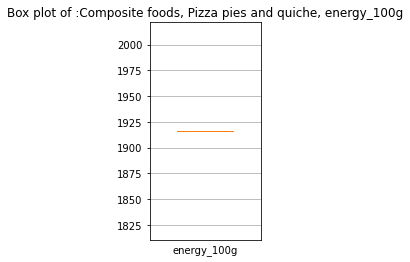

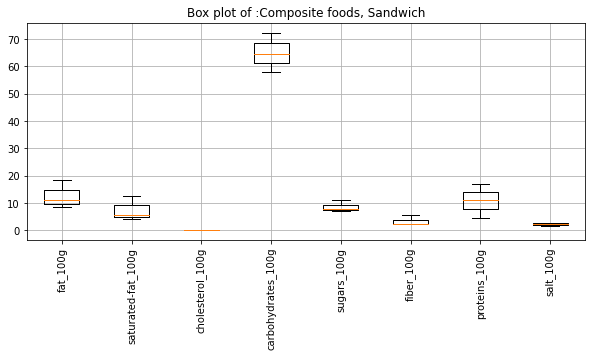

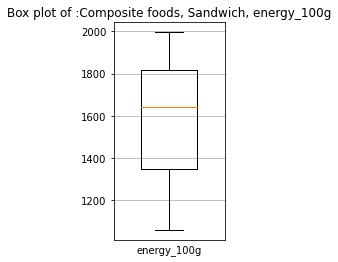

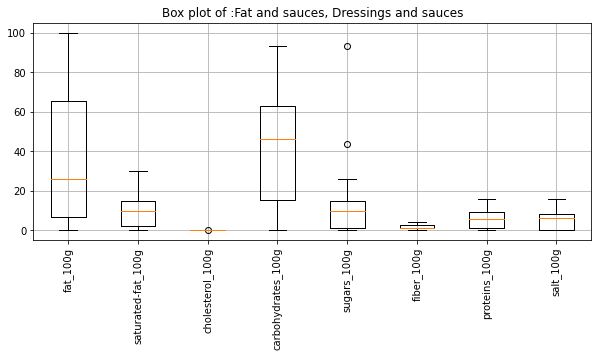

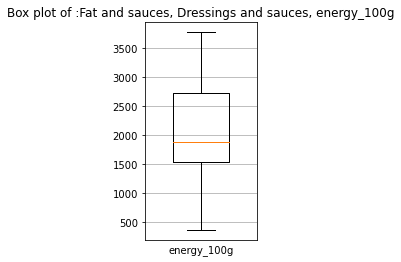

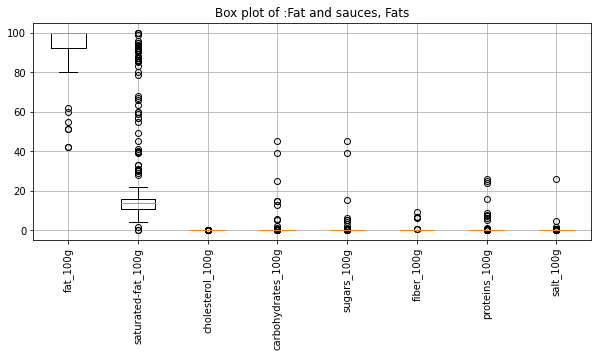

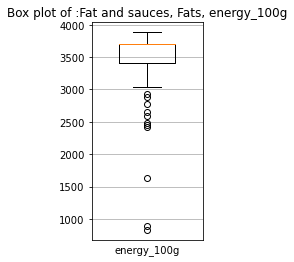

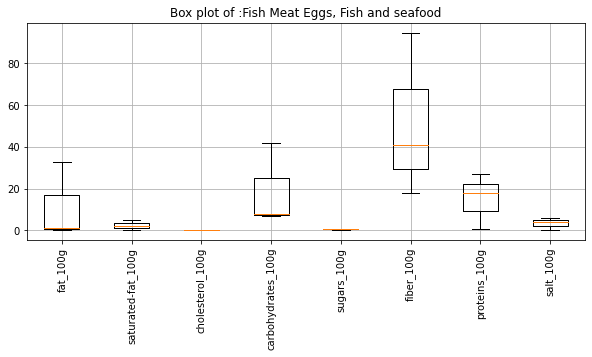

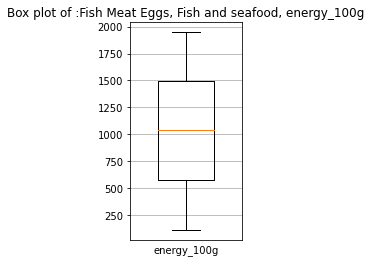

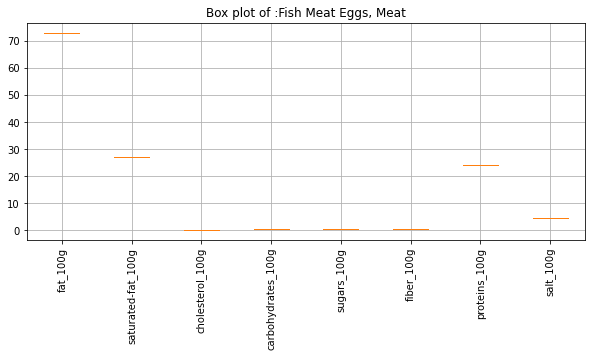

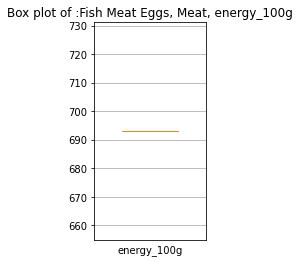

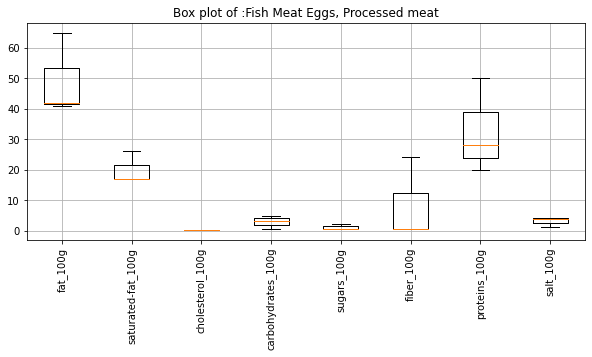

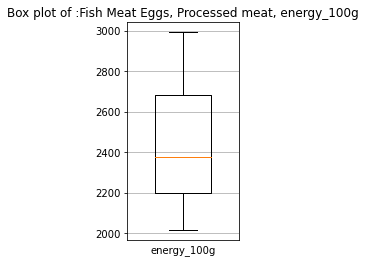

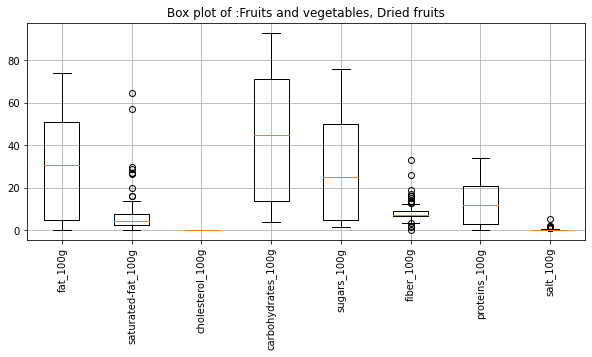

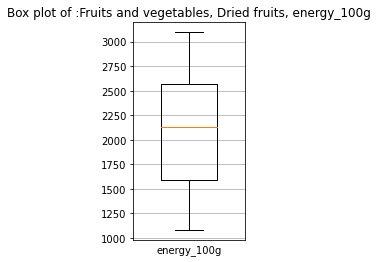

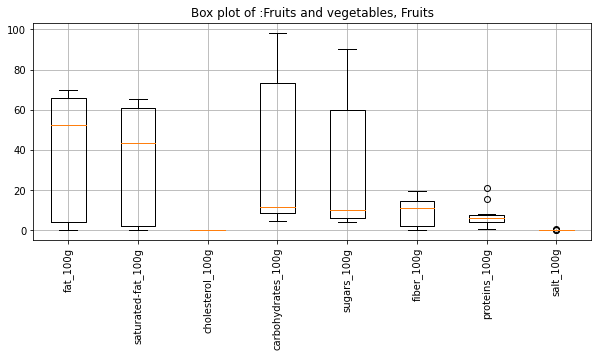

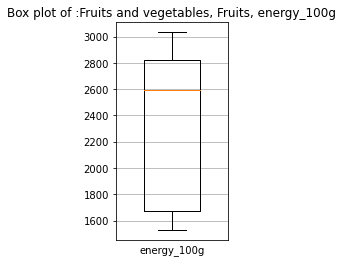

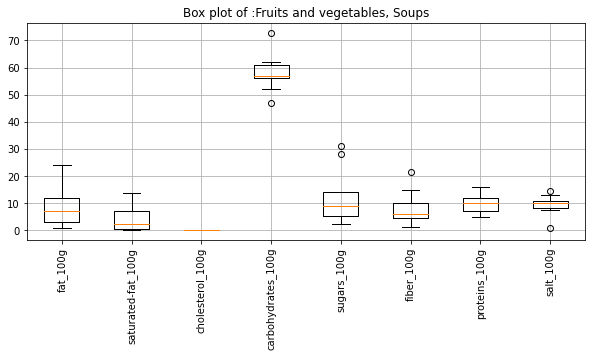

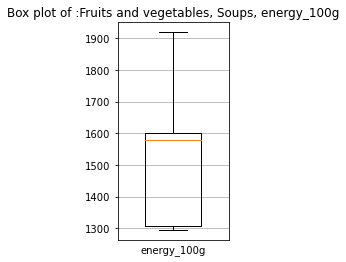

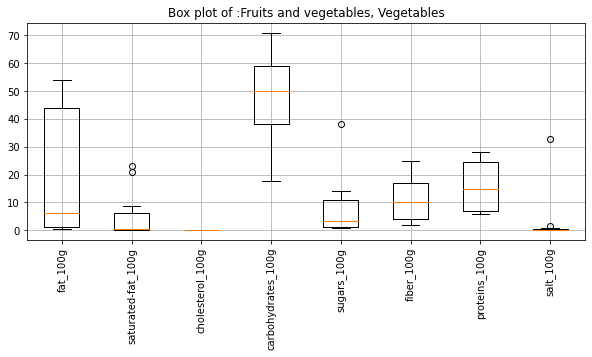

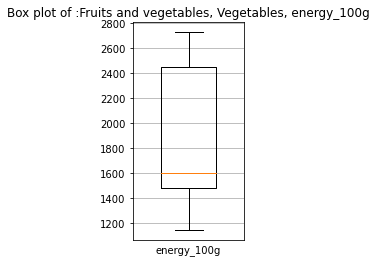

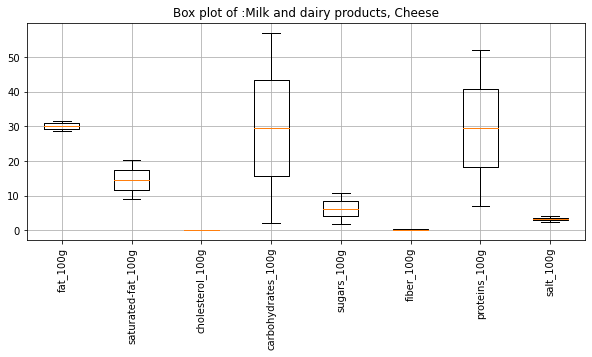

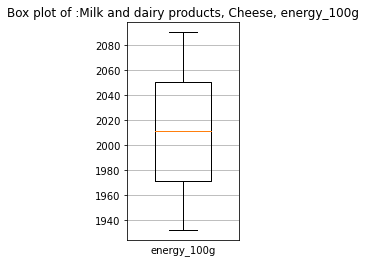

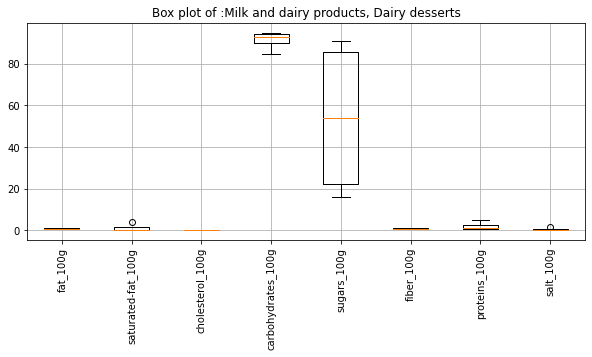

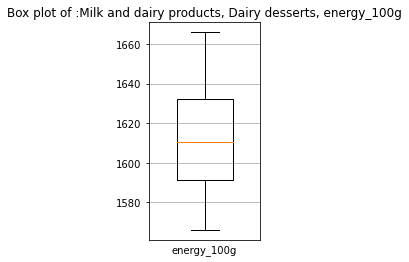

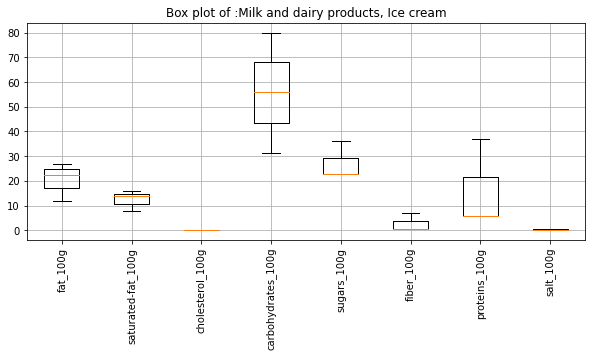

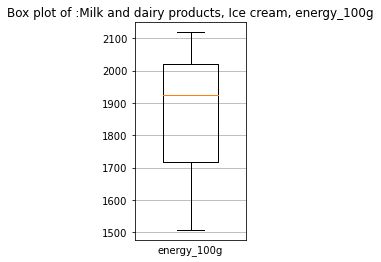

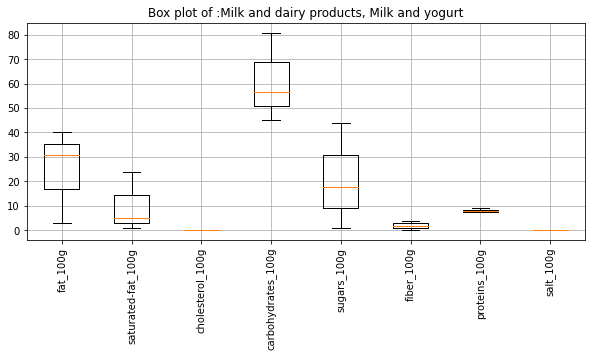

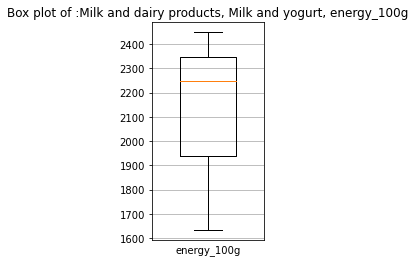

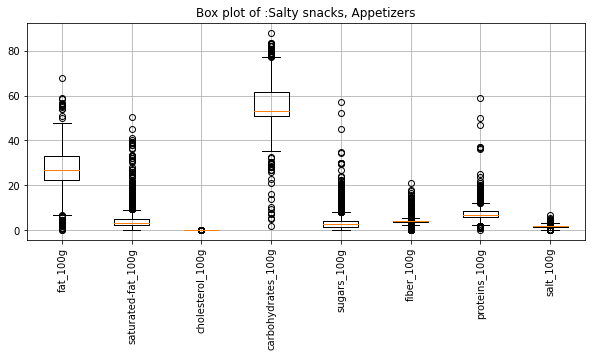

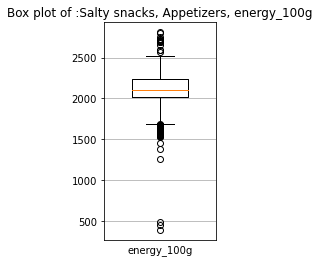

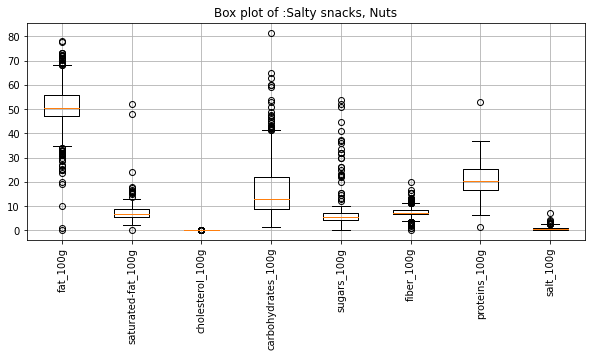

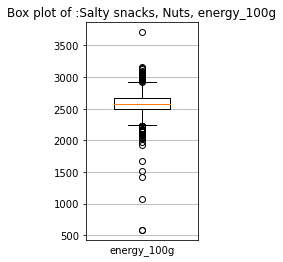

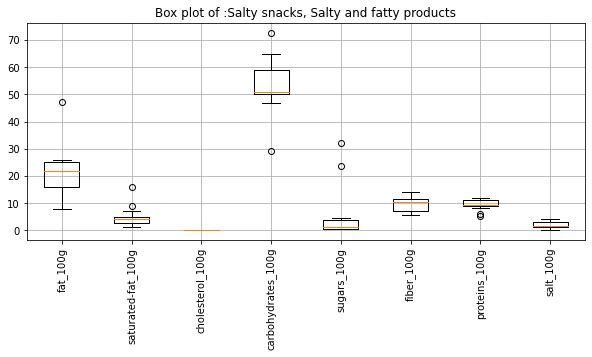

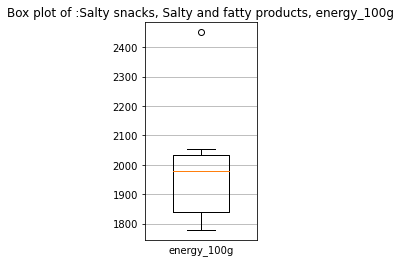

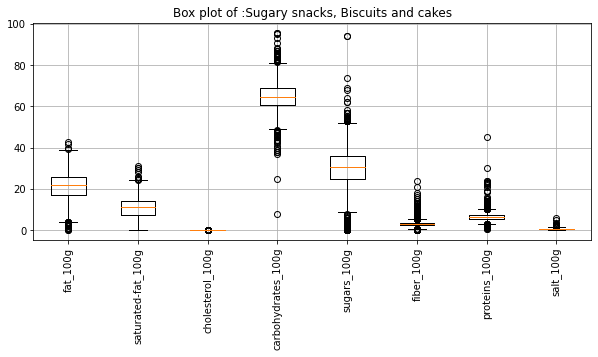

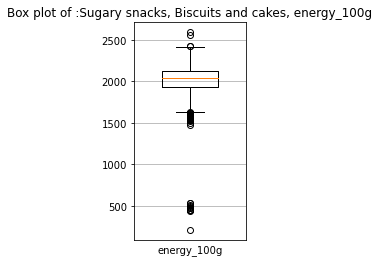

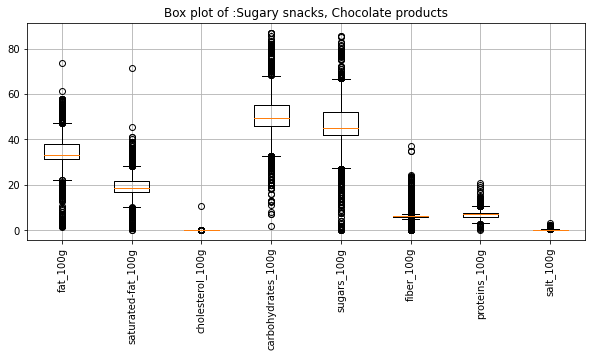

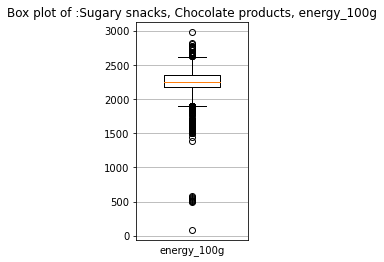

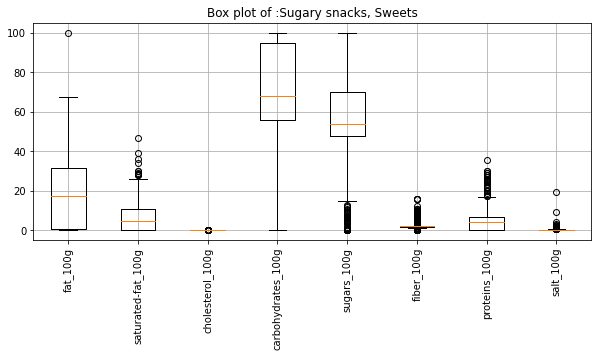

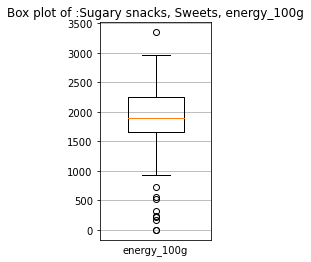

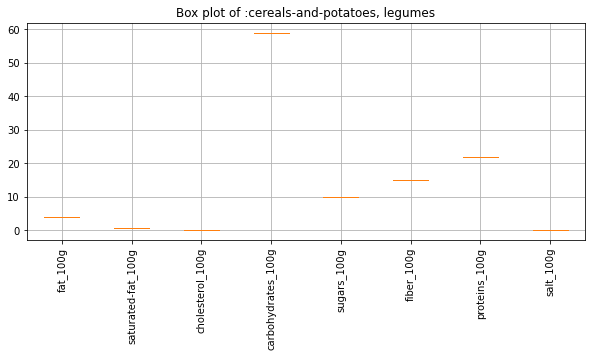

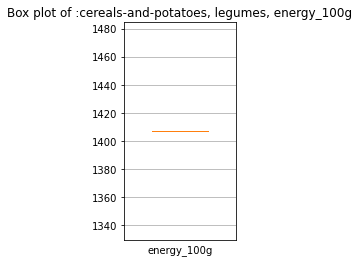

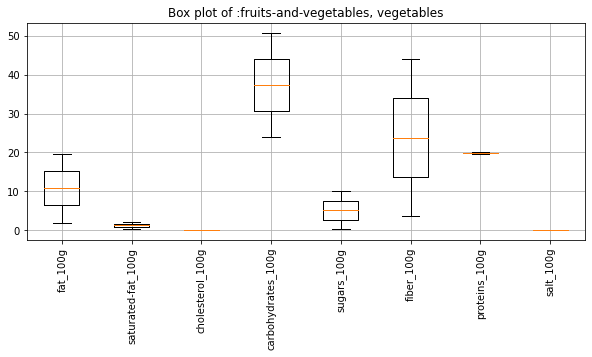

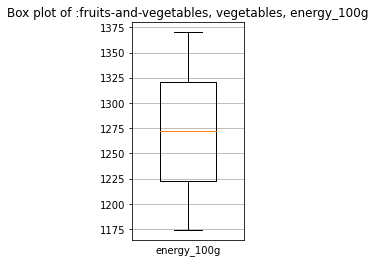

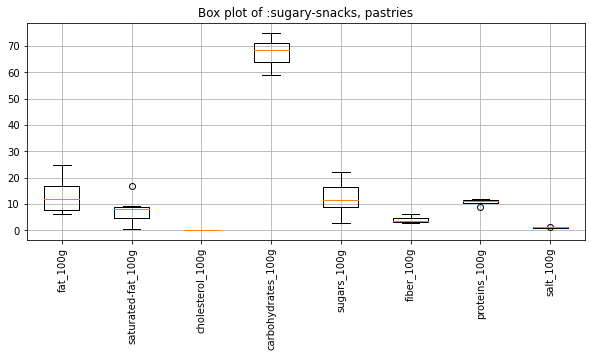

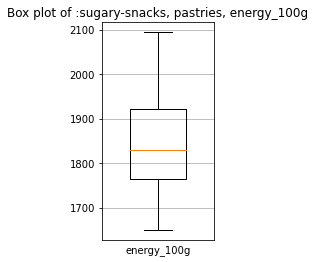

In [4]:
##  quantitative_features_100
data_group = (data.groupby(['pnns_groups_1','pnns_groups_2']).mean()).index
for i in data_group:
    x = [(data.loc[((data['pnns_groups_1']== i[0])&(data['pnns_groups_2'] == i[1]))])[j] for j in quantitative_features_100]
# BOX PLOT    
    fig = plt.figure(figsize=(10,4))
    plt.boxplot(x, widths=0.5)
    plt.xticks(list(range(1,len(quantitative_features_100)+1)),quantitative_features_100, rotation = 90)
    plt.title('Box plot of :'+i[0]+', '+i[1])
    plt.grid()
    plt.show()
    
## energy_100g
    x = (data.loc[((data['pnns_groups_1']== i[0])&(data['pnns_groups_2'] == i[1]))])['energy_100g']
# BOX PLOT
    fig = plt.figure(figsize=(2,4))
    plt.boxplot(x, widths=0.5)
    plt.xticks([])
    plt.xlabel('energy_100g')
    plt.title('Box plot of :'+i[0]+', '+i[1]+', energy_100g')
    plt.grid()
    plt.show()


#### 5.2.2 Quantitative features distribution

<Figure size 360x360 with 0 Axes>

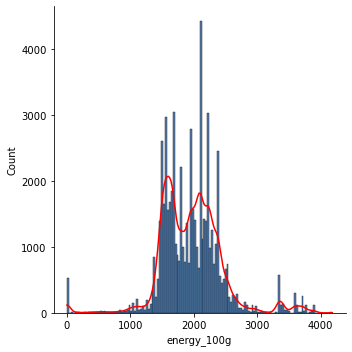

<Figure size 360x360 with 0 Axes>

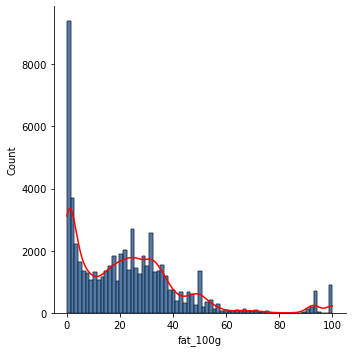

<Figure size 360x360 with 0 Axes>

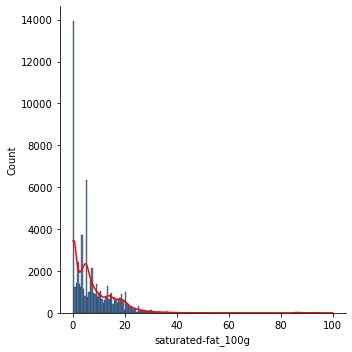

<Figure size 360x360 with 0 Axes>

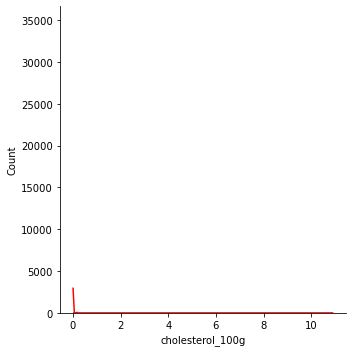

<Figure size 360x360 with 0 Axes>

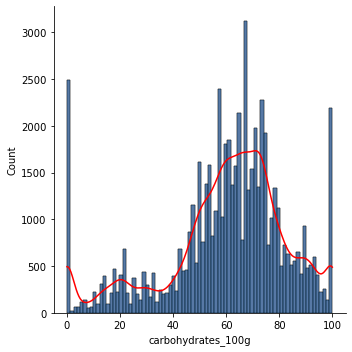

<Figure size 360x360 with 0 Axes>

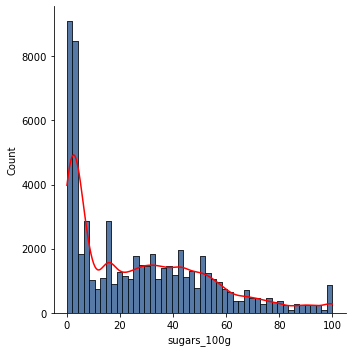

<Figure size 360x360 with 0 Axes>

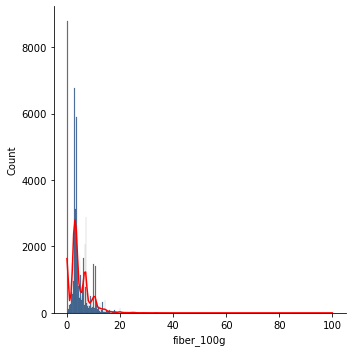

<Figure size 360x360 with 0 Axes>

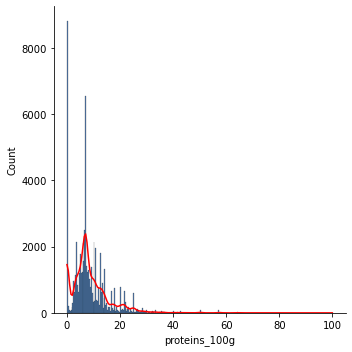

<Figure size 360x360 with 0 Axes>

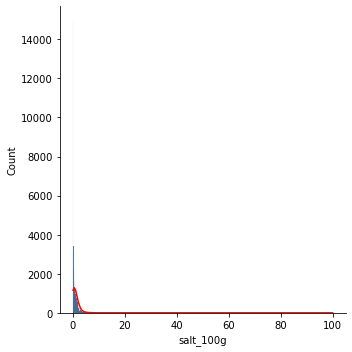

In [5]:

for i in quantitative_features:  
    plt.figure(figsize = (5,5))
    sns.displot(data, x=i,kde=True, color= 'red')
    sns.histplot(data, x = i)
    plt.show()
    plt.close()

#### 5.2.3 ANOVA PNNS_GROUPS_1

In [6]:
"""
The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent.

2. Each sample is from a normally distributed population.

3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
"""
anova_pnns1_dic={}
for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_1']== i, j] for i in data_pnns['pnns_groups_1'].unique()]
    f, p = f_oneway(*x)
    anova_pnns1_dic[str(j)] = f,p

anova_pnns1_dataframe = pd.DataFrame.from_dict(anova_pnns1_dic, orient='index', columns=['F_statistics','p-values']).sort_values('p-values', ascending=False)
anova_pnns1_dataframe   


F_statistics       p-values
cholesterol_100g      124.440153  4.509190e-272
energy_100g          1694.200128   0.000000e+00
fat_100g             2107.148301   0.000000e+00
saturated-fat_100g    491.663730   0.000000e+00
carbohydrates_100g    851.593744   0.000000e+00
sugars_100g          1573.172442   0.000000e+00
fiber_100g            200.518792   0.000000e+00
proteins_100g         403.426138   0.000000e+00
salt_100g             259.396382   0.000000e+00

##### normal test

In [7]:
"""
The normaltest function tests the null hypothesis that a sample comes from a normal distribution.
"""
for j in quantitative_features:
    normal_test_dic = {}
    x = {i:data_pnns.loc[data_pnns['pnns_groups_1']== i, j] for i in data_pnns['pnns_groups_1'].unique()}
    for key,value in x.items(): 
        if len(value)>12:
            normal_test_dic[key] = stats.normaltest(value)
    print(j)
    display(pd.DataFrame.from_dict(normal_test_dic , orient='index'))


energy_100g


statistic         pvalue
Sugary snacks          2318.623775   0.000000e+00
Cereals and potatoes    715.711506  3.847877e-156
Fat and sauces          515.681565  1.049956e-112
Salty snacks            177.727644   2.552305e-39
Fruits and vegetables    55.815634   7.582092e-13
Beverages                54.218809   1.684749e-12
Composite foods          28.131941   7.784427e-07

fat_100g


statistic         pvalue
Sugary snacks           192.974944   1.247451e-42
Cereals and potatoes   1424.356462  5.069022e-310
Fat and sauces          578.541259  2.351591e-126
Salty snacks            147.557715   9.083418e-33
Fruits and vegetables   155.868018   1.424590e-34
Beverages                92.111134   9.961422e-21
Composite foods          68.723472   1.193679e-15

saturated-fat_100g


statistic         pvalue
Sugary snacks            16.302723   2.883426e-04
Cereals and potatoes   1267.826811  4.953428e-276
Fat and sauces          330.193040   1.992931e-72
Salty snacks           1641.848603   0.000000e+00
Fruits and vegetables    66.459736   3.702131e-15
Beverages                88.665003   5.580065e-20
Composite foods          19.778939   5.070584e-05

cholesterol_100g


statistic        pvalue
Sugary snacks          21602.621067  0.000000e+00
Cereals and potatoes    5949.321247  0.000000e+00
Fat and sauces           236.737745  3.917887e-52
Salty snacks            4182.979311  0.000000e+00
Fruits and vegetables     62.010455  3.424529e-14
Beverages                247.609281  1.707371e-54
Composite foods           73.894102  8.997038e-17

carbohydrates_100g


statistic         pvalue
Sugary snacks           313.884445   6.932005e-69
Cereals and potatoes   1399.213417  1.461057e-304
Fat and sauces          703.820437  1.470056e-153
Salty snacks            299.532181   9.065949e-66
Fruits and vegetables    73.510908   1.089705e-16
Beverages                18.483225   9.692119e-05
Composite foods          36.577271   1.141160e-08

sugars_100g


statistic         pvalue
Sugary snacks           645.597090  6.462092e-141
Cereals and potatoes    341.867840   5.812216e-75
Fat and sauces         1045.010336  1.199192e-227
Salty snacks           2192.405659   0.000000e+00
Fruits and vegetables    18.124340   1.159710e-04
Beverages                 7.911973   1.913978e-02
Composite foods          40.874703   1.330978e-09

fiber_100g


statistic         pvalue
Sugary snacks          3118.419441   0.000000e+00
Cereals and potatoes   2091.649074   0.000000e+00
Fat and sauces          832.657055  1.551736e-181
Salty snacks            838.587600  7.998643e-183
Fruits and vegetables    39.674547   2.425390e-09
Beverages                67.756284   1.936020e-15
Composite foods          20.107572   4.302256e-05

proteins_100g


statistic         pvalue
Sugary snacks          2773.851276   0.000000e+00
Cereals and potatoes   2163.099358   0.000000e+00
Fat and sauces          782.351430  1.301804e-170
Salty snacks            745.777424  1.138912e-162
Fruits and vegetables    17.660087   1.462719e-04
Beverages                98.946136   3.266777e-22
Composite foods          44.403505   2.279824e-10

salt_100g


statistic         pvalue
Sugary snacks          11939.041774   0.000000e+00
Cereals and potatoes    2496.007943   0.000000e+00
Fat and sauces           904.868518  3.238157e-197
Salty snacks             243.330174   1.450522e-53
Fruits and vegetables    167.640188   3.957271e-37
Beverages                254.098584   6.655698e-56
Composite foods          144.982633   3.291708e-32

##### quantitative features pnns_groups_1 distribution

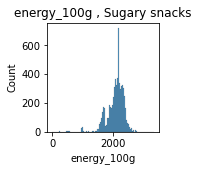

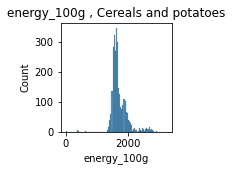

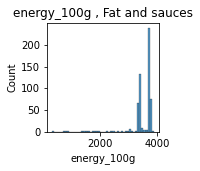

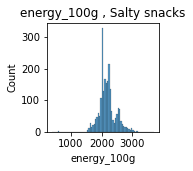

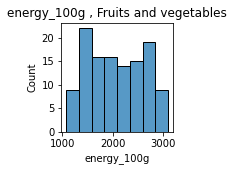

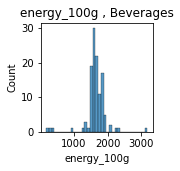

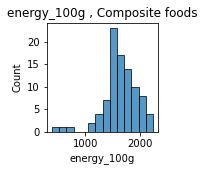

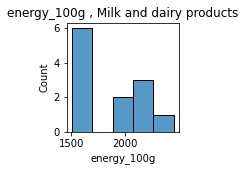

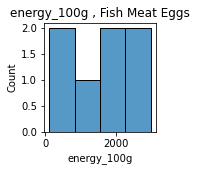

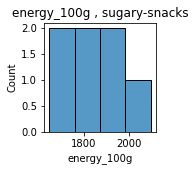

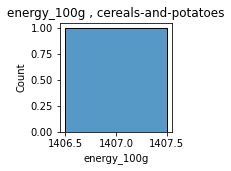

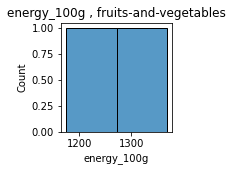

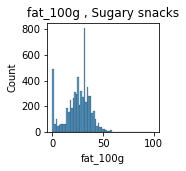

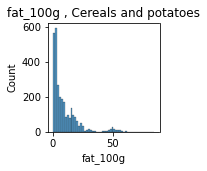

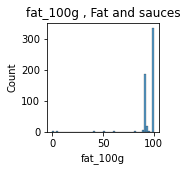

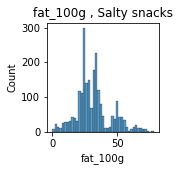

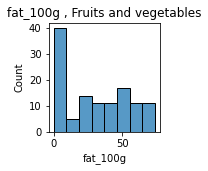

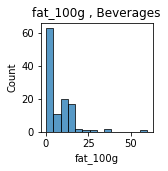

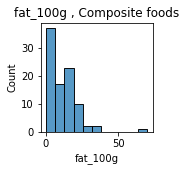

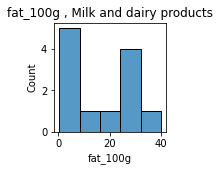

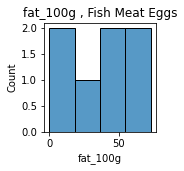

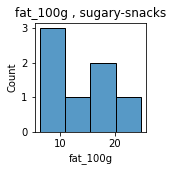

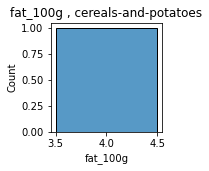

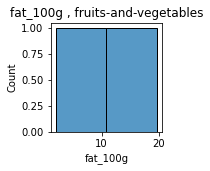

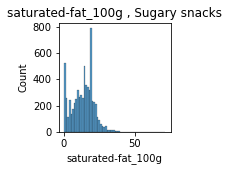

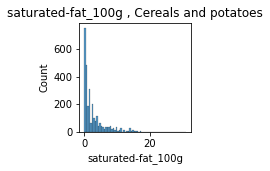

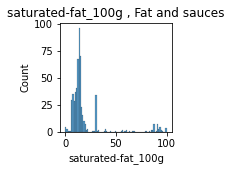

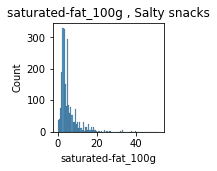

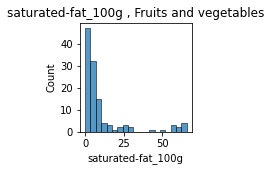

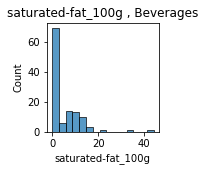

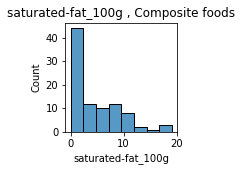

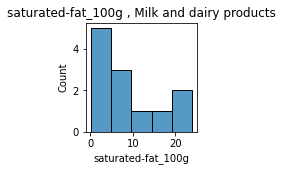

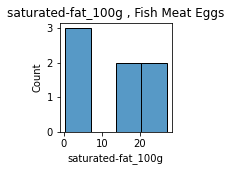

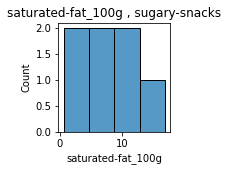

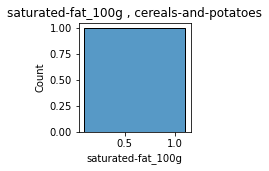

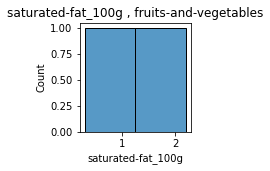

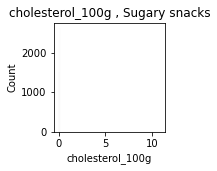

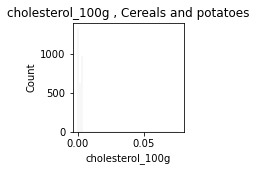

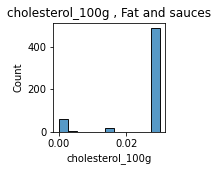

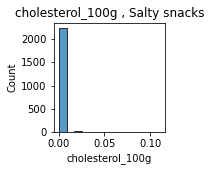

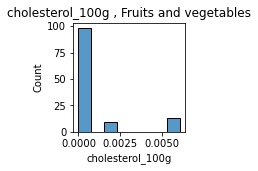

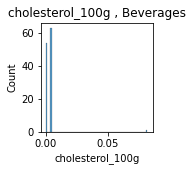

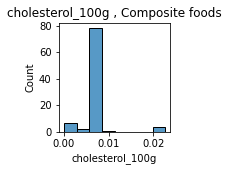

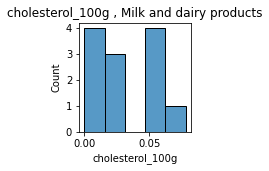

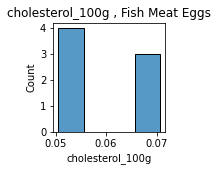

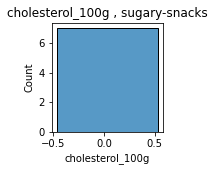

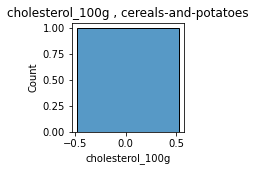

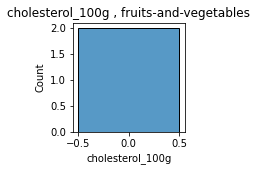

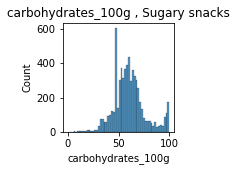

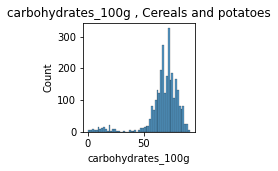

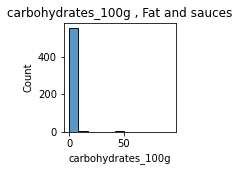

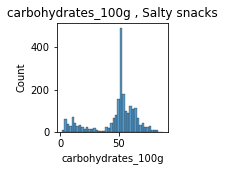

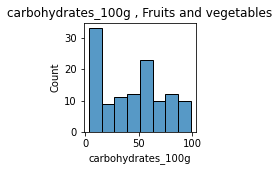

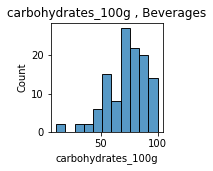

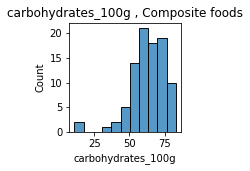

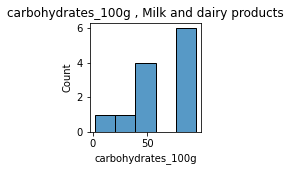

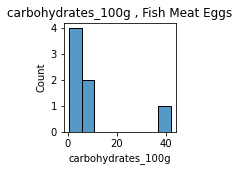

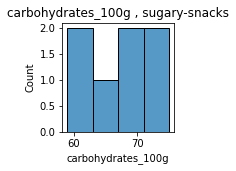

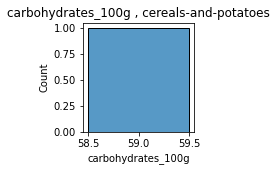

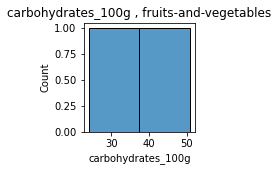

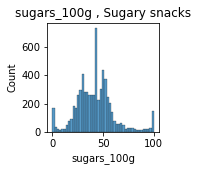

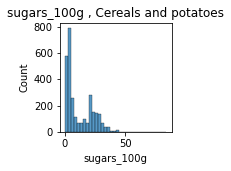

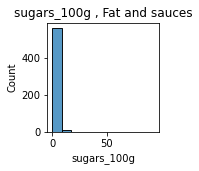

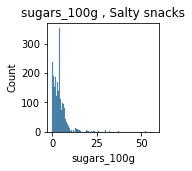

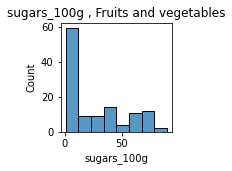

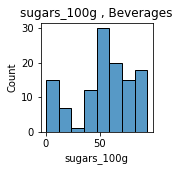

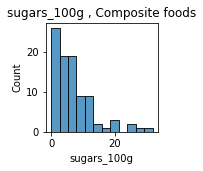

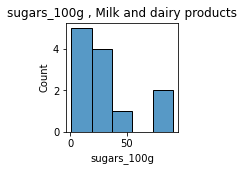

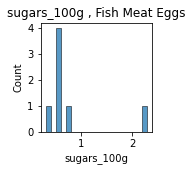

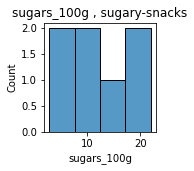

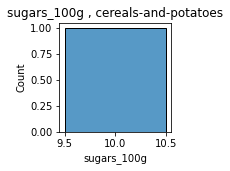

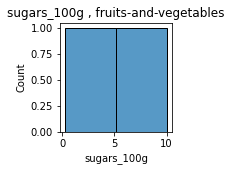

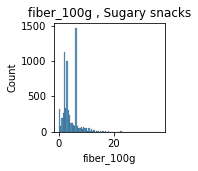

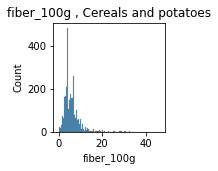

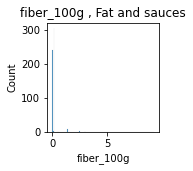

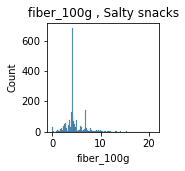

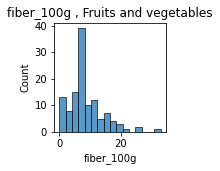

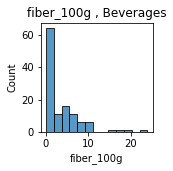

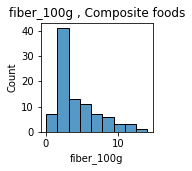

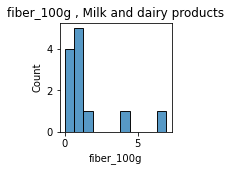

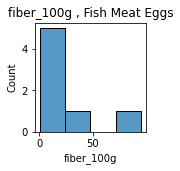

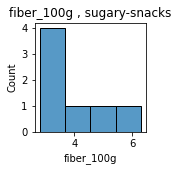

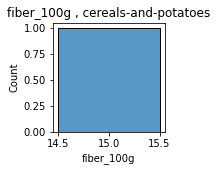

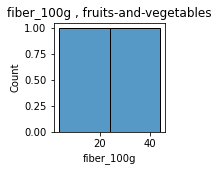

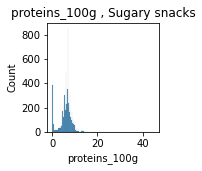

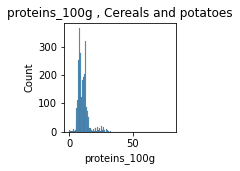

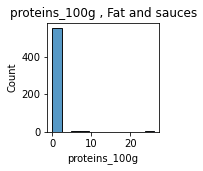

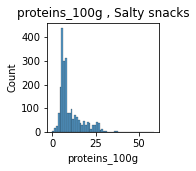

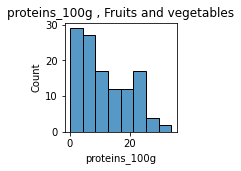

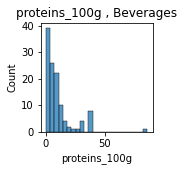

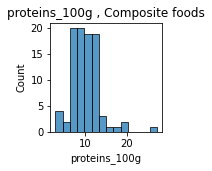

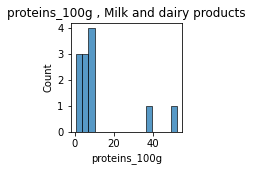

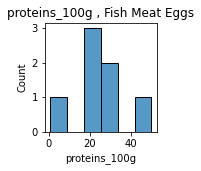

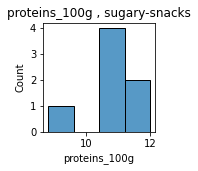

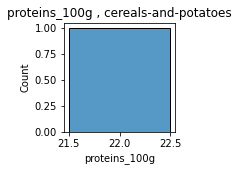

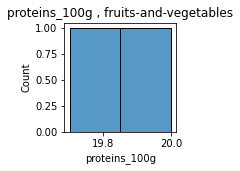

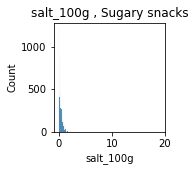

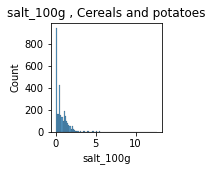

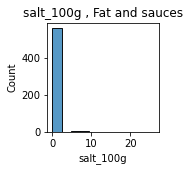

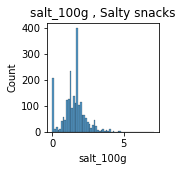

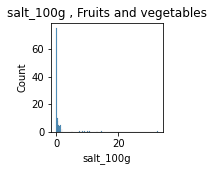

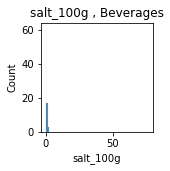

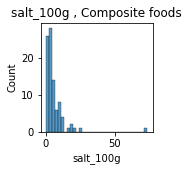

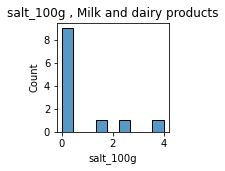

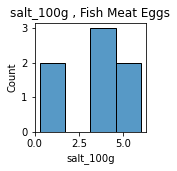

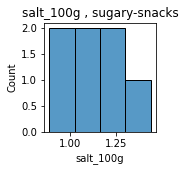

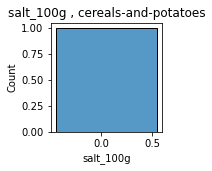

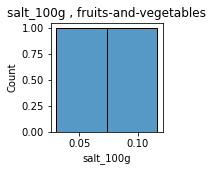

In [33]:
for i in quantitative_features:
    for j in data_pnns['pnns_groups_1'].unique():
        plt.figure(figsize = (2,2))
#         sns.displot(data.loc[data['pnns_groups_1']==j], x=i,kde=True, color= 'red')
        sns.histplot(data.loc[data['pnns_groups_1']==j], x = i)
        plt.title(i+' , '+j)
        plt.show()
        plt.close()

##### levene

In [32]:
"""
The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
"""
levene_test_dic = {}
for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_1']== i, j] for i in data_pnns['pnns_groups_1'].unique()]
    levene_test_dic[j] = stats.levene(*x)
    
pd.DataFrame.from_dict(levene_test_dic , orient='index')
   

statistic         pvalue
energy_100g          27.077311   1.266289e-56
fat_100g             43.324775   2.166514e-93
saturated-fat_100g  138.413560  7.865469e-302
cholesterol_100g     84.738809  7.536145e-186
carbohydrates_100g   59.655262  3.987235e-130
sugars_100g         236.288867   0.000000e+00
fiber_100g           99.617969  1.875239e-218
proteins_100g       142.062178  1.498556e-309
salt_100g           104.608965  2.594237e-229

##### BoxPlot

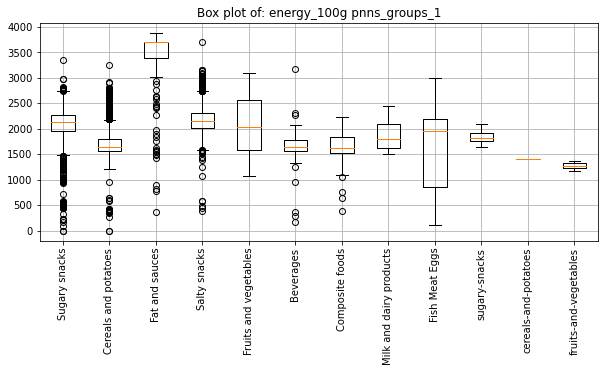

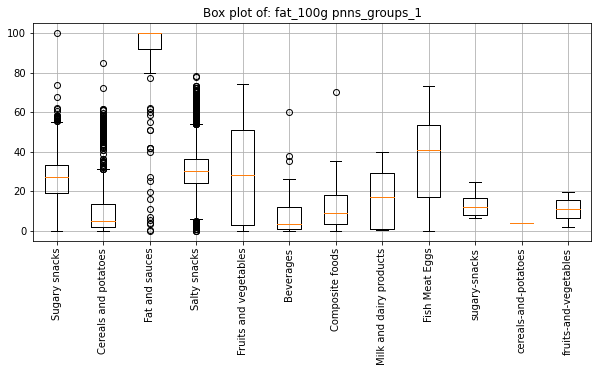

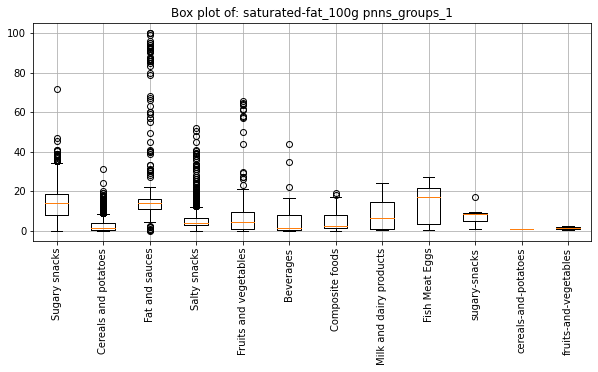

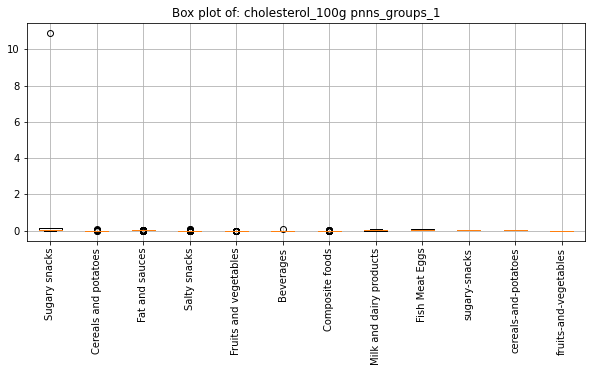

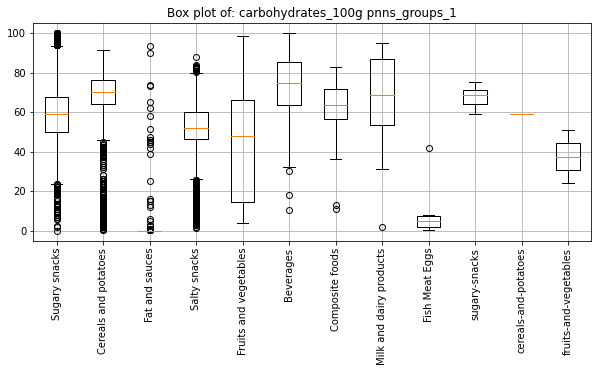

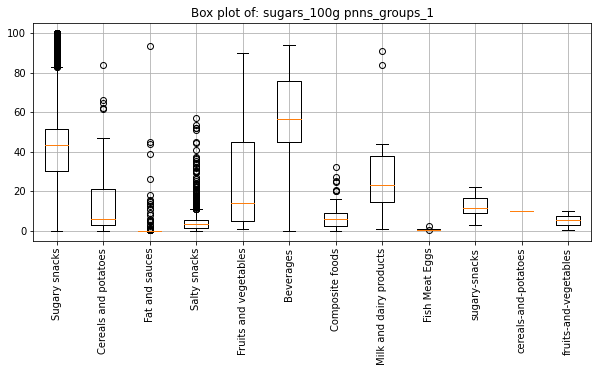

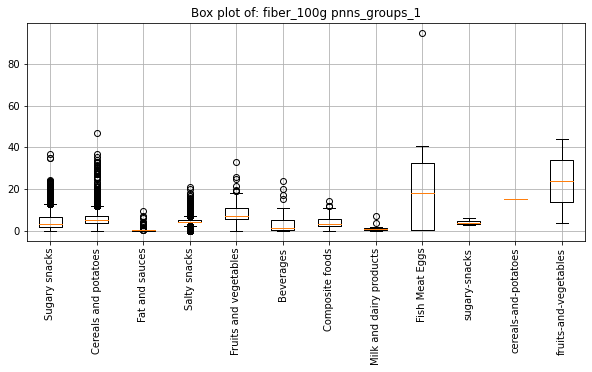

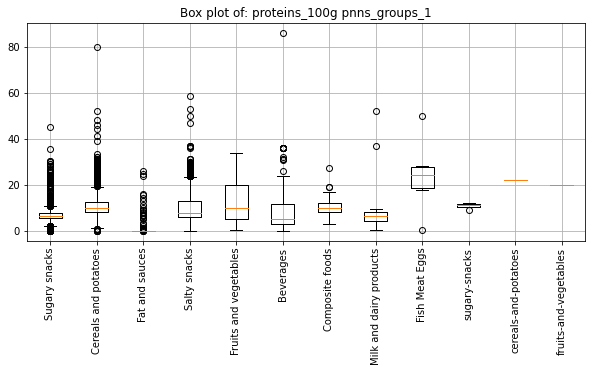

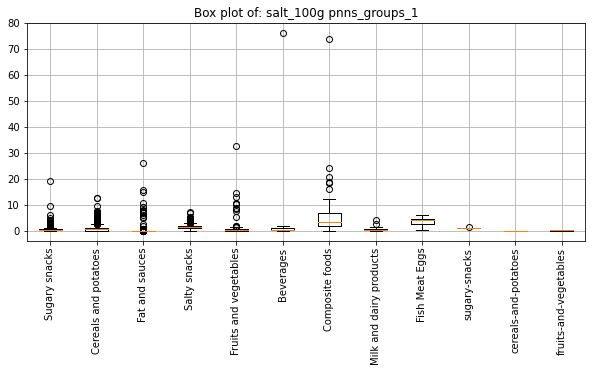

In [9]:


for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_1']== i, j] for i in data_pnns['pnns_groups_1'].unique()]
    fig = plt.figure(figsize=(10,4))
    plt.boxplot(x, widths=0.5,)
    plt.xticks(list(range(1,len(data_pnns['pnns_groups_1'].unique())+1)),list(data_pnns['pnns_groups_1'].unique()), rotation = 90)
    plt.title('Box plot of: '+j+' pnns_groups_1')
    plt.grid()
    plt.show()
    

#### 5.2.4 ANOVA PNNS_GROUPS_2

In [10]:
anova_pnns2_dic={}
for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_2']== i, j] for i in data_pnns['pnns_groups_2'].unique()]
    f, p = f_oneway(*x)
    anova_pnns2_dic[str(j)] = f,p

anova_pnns2_dataframe = pd.DataFrame.from_dict(anova_pnns2_dic, orient='index', columns=['F_statistics','p-values']).sort_values('p-values', ascending=False)
anova_pnns2_dataframe

F_statistics  p-values
energy_100g           880.076507       0.0
fat_100g             1307.931627       0.0
saturated-fat_100g    332.944747       0.0
cholesterol_100g      149.982729       0.0
carbohydrates_100g    774.537278       0.0
sugars_100g           957.154400       0.0
fiber_100g            193.778707       0.0
proteins_100g         462.492656       0.0
salt_100g             142.093494       0.0

##### normal test

In [11]:
"""
The normaltest function tests the null hypothesis that a sample comes from a normal distribution.
"""
for j in quantitative_features:
    normal_test_dic = {}
    x = {i:data_pnns.loc[data_pnns['pnns_groups_2']== i, j] for i in data_pnns['pnns_groups_2'].unique()}
    for key,value in x.items(): 
        if len(value)>12:
            normal_test_dic[key] = stats.normaltest(value)
    print(j)
    display(pd.DataFrame.from_dict(normal_test_dic , orient='index'))


energy_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                     123.379902   1.615827e-27
Biscuits and cakes        1784.000178   0.000000e+00
Chocolate products        1686.460278   0.000000e+00
Cereals                    311.406729   2.392698e-68
Fats                       580.235714  1.007896e-126
Appetizers                 576.830841  5.530626e-126
Nuts                       258.040620   9.272384e-57
Breakfast cereals          451.854657   7.603401e-99
Dried fruits                12.375107   2.054848e-03
Legumes                     17.943841   1.269242e-04
Sweetened beverages         81.740568   1.779349e-18
Non-sugared beverages       16.915135   2.122878e-04
Bread                      260.523913   2.678866e-57
One-dish meals              29.077630   4.851463e-07
Dressings and sauces         0.629396   7.300094e-01
Vegetables                   3.809929   1.488279e-01
Salty and fatty products    13.174925   1.377531e-03
Fruits                      11.859454   2.659208e-03

fat_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                    149.501671   3.436565e-33
Biscuits and cakes        106.601979   7.106803e-24
Chocolate products        672.205346  1.077616e-146
Cereals                   605.059329  4.102382e-132
Fats                      528.210208  1.998070e-115
Appetizers                100.024591   1.905180e-22
Nuts                       72.291067   2.005369e-16
Breakfast cereals         170.676710   8.670086e-38
Dried fruits               34.473918   3.266509e-08
Legumes                    22.534087   1.278749e-05
Sweetened beverages        30.981437   1.872692e-07
Non-sugared beverages      45.534893   1.294862e-10
Bread                     208.183637   6.215807e-46
One-dish meals             67.287927   2.446878e-15
Dressings and sauces        3.888091   1.431237e-01
Vegetables                  7.643398   2.189058e-02
Salty and fatty products   11.193616   3.709687e-03
Fruits                     12.547673   1.884983e-03

saturated-fat_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                     205.913793   1.933695e-45
Biscuits and cakes           3.199157   2.019816e-01
Chocolate products         313.764114   7.361873e-69
Cereals                    498.015488  7.199641e-109
Fats                       313.874457   6.966710e-69
Appetizers                1254.006829  4.964516e-273
Nuts                       586.203254  5.100125e-128
Breakfast cereals          277.972510   4.355483e-61
Dried fruits                82.951432   9.712372e-19
Legumes                      1.226810   5.415039e-01
Sweetened beverages         38.910212   3.554306e-09
Non-sugared beverages       58.659266   1.829373e-13
Bread                      457.569569  4.365465e-100
One-dish meals              21.415035   2.237610e-05
Dressings and sauces         2.794348   2.472948e-01
Vegetables                   9.012290   1.104094e-02
Salty and fatty products    16.721437   2.338762e-04
Fruits                      19.678658   5.331308e-05

cholesterol_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                    2045.469030   0.000000e+00
Biscuits and cakes        2827.626795   0.000000e+00
Chocolate products        8569.724836   0.000000e+00
Cereals                   2338.111907   0.000000e+00
Fats                       263.516599   5.999258e-58
Appetizers                3853.355312   0.000000e+00
Nuts                      1037.175694  6.027812e-226
Breakfast cereals         2983.097966   0.000000e+00
Dried fruits               457.772881  3.943500e-100
Legumes                     46.375608   8.504811e-11
Sweetened beverages        142.355605   1.224258e-31
Non-sugared beverages       82.856528   1.018436e-18
Bread                      943.945779  1.058714e-205
One-dish meals              71.436506   3.074396e-16
Dressings and sauces        51.660733   6.053608e-12
Vegetables                 724.681324  4.339602e-158
Salty and fatty products   724.681324  4.339602e-158
Fruits                     522.432010  3.591951e-114

carbohydrates_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                     101.495778   9.130022e-23
Biscuits and cakes         186.910862   2.587153e-41
Chocolate products         129.368300   8.091531e-29
Cereals                    661.336296  2.469721e-144
Fats                      1008.349633  1.095619e-219
Appetizers                 207.564163   8.472560e-46
Nuts                       154.066586   3.506437e-34
Breakfast cereals           12.870125   1.604309e-03
Dried fruits                74.106173   8.091873e-17
Legumes                     19.875781   4.830911e-05
Sweetened beverages         30.712864   2.141836e-07
Non-sugared beverages        1.651071   4.380004e-01
Bread                      106.416074   7.799074e-24
One-dish meals              35.210833   2.259773e-08
Dressings and sauces         1.256685   5.334754e-01
Vegetables                   0.651086   7.221352e-01
Salty and fatty products     3.217459   2.001418e-01
Fruits                       8.824123   1.213014e-02

sugars_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                       9.351969   9.316349e-03
Biscuits and cakes         156.980047   8.169886e-35
Chocolate products         366.224310   2.988145e-80
Cereals                    751.186147  7.620803e-164
Fats                      1117.139826  2.607168e-243
Appetizers                1805.620013   0.000000e+00
Nuts                       409.336347   1.299396e-89
Breakfast cereals           31.302737   1.594766e-07
Dried fruits                37.369242   7.680193e-09
Legumes                     55.962288   7.046015e-13
Sweetened beverages          2.275471   3.205441e-01
Non-sugared beverages       16.171677   3.078684e-04
Bread                      779.910659  4.411155e-170
One-dish meals              38.946590   3.490241e-09
Dressings and sauces        33.235168   6.068409e-08
Vegetables                  21.126731   2.584572e-05
Salty and fatty products    15.678082   3.940468e-04
Fruits                       5.355533   6.871648e-02

C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


fiber_100g


statistic         pvalue
Sweets                     914.635411  2.451568e-199
Biscuits and cakes        1630.210975   0.000000e+00
Chocolate products        1271.200444  9.169191e-277
Cereals                   1102.976788  3.101942e-240
Fats                      1002.748874  1.802389e-218
Appetizers                1181.698732  2.496782e-257
Nuts                        57.917197   2.651187e-13
Breakfast cereals          731.049167  1.797589e-159
Dried fruits                63.644557   1.512726e-14
Legumes                     82.057836   1.518334e-18
Sweetened beverages          7.405027   2.466146e-02
Non-sugared beverages       29.923865   3.177718e-07
Bread                      319.326972   4.560674e-70
One-dish meals              18.195427   1.119215e-04
Dressings and sauces         0.628308   7.304067e-01
Vegetables                   1.536761   4.637636e-01
Salty and fatty products     1.195000   5.501853e-01
Fruits                       6.688748   3.528229e-02

proteins_100g


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


statistic         pvalue
Sweets                     586.225681  5.043253e-128
Biscuits and cakes        2622.757986   0.000000e+00
Chocolate products         665.913273  2.504782e-145
Cereals                   1066.040704  3.252388e-232
Fats                       935.139125  8.652054e-204
Appetizers                1626.118646   0.000000e+00
Nuts                        20.897474   2.898485e-05
Breakfast cereals         1123.387515  1.146834e-244
Dried fruits                21.418344   2.233910e-05
Legumes                     44.545918   2.123131e-10
Sweetened beverages          4.694604   9.562681e-02
Non-sugared beverages       31.733014   1.286067e-07
Bread                       39.344860   2.860041e-09
One-dish meals              48.838446   2.482369e-11
Dressings and sauces         2.027455   3.628638e-01
Vegetables                   5.941085   5.127549e-02
Salty and fatty products     3.109622   2.112293e-01
Fruits                      12.907497   1.574609e-03

C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


salt_100g


statistic         pvalue
Sweets                    3302.426705   0.000000e+00
Biscuits and cakes        1668.297517   0.000000e+00
Chocolate products        2961.024771   0.000000e+00
Cereals                    846.825683  1.300587e-184
Fats                      1331.997004  5.761367e-290
Appetizers                 447.362842   7.184445e-98
Nuts                       202.002108   1.367098e-44
Breakfast cereals         1219.576522  1.487042e-265
Dried fruits               109.327246   1.819241e-24
Legumes                    237.405587   2.805639e-52
Sweetened beverages        142.310840   1.251970e-31
Non-sugared beverages       13.213789   1.351022e-03
Bread                       11.797397   2.743013e-03
One-dish meals             138.594441   8.027857e-31
Dressings and sauces         1.135713   5.667389e-01
Vegetables                  35.882852   1.614871e-08
Salty and fatty products     1.065016   5.871307e-01
Fruits                      32.242905   9.966486e-08

##### levene

In [31]:
"""
The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
"""
levene_test_dic = {}
for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_2']== i, j] for i in data_pnns['pnns_groups_2'].unique()]
    levene_test_dic[j] = stats.levene(*x)
    
display(pd.DataFrame.from_dict(levene_test_dic , orient='index'))
   

statistic         pvalue
energy_100g          65.528560   0.000000e+00
fat_100g             93.972763   0.000000e+00
saturated-fat_100g   42.672750  7.351937e-260
cholesterol_100g      0.344916   9.998316e-01
carbohydrates_100g  124.060493   0.000000e+00
sugars_100g         130.188138   0.000000e+00
fiber_100g           42.053617  5.904431e-256
proteins_100g        99.065449   0.000000e+00
salt_100g            51.360299  3.553818e-314

##### Box Plot

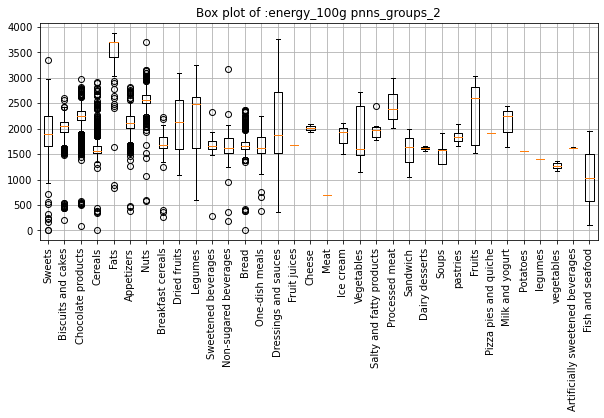

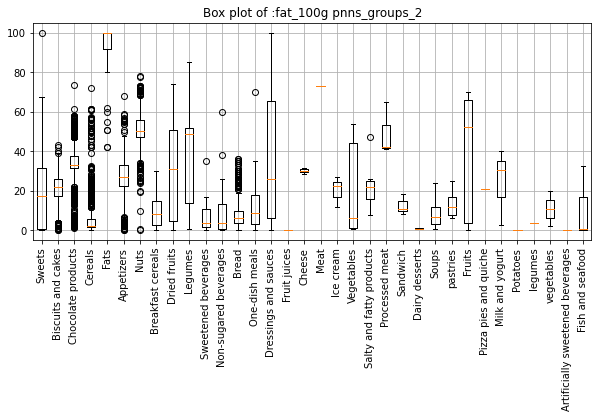

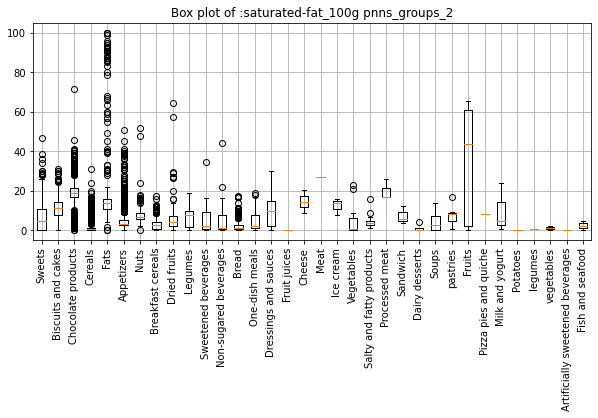

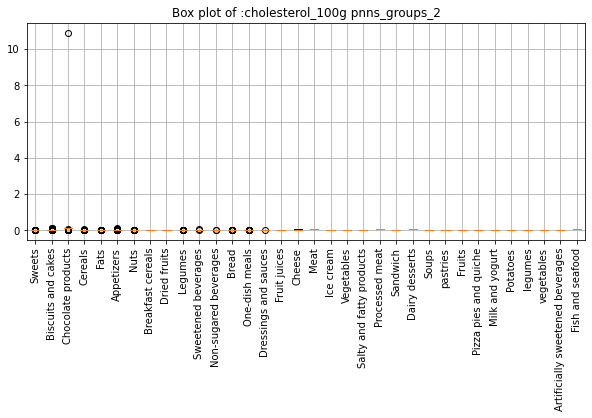

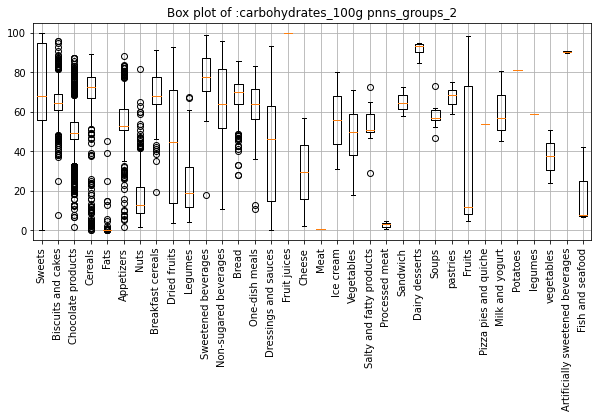

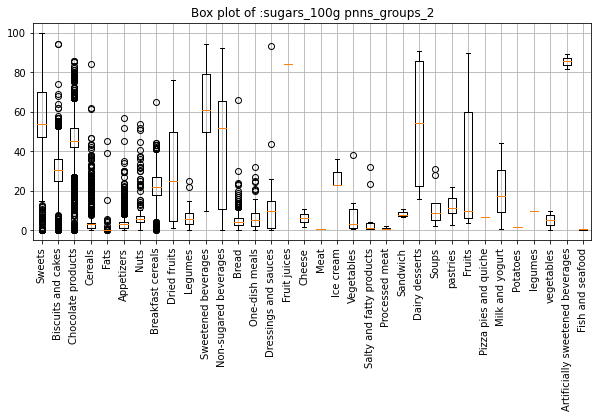

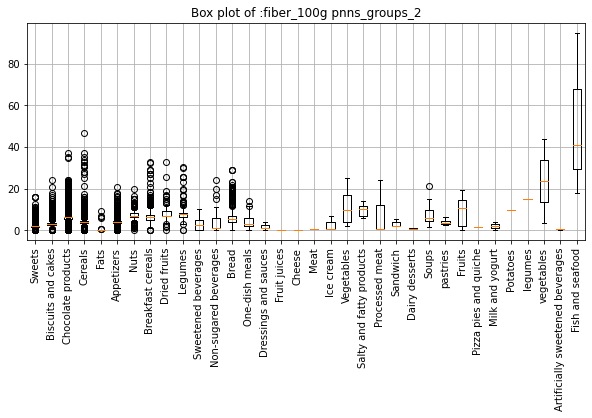

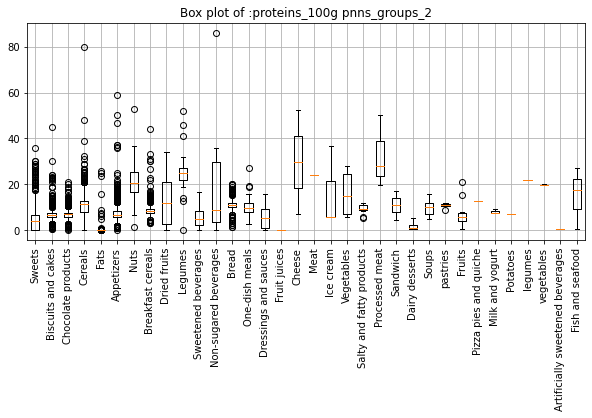

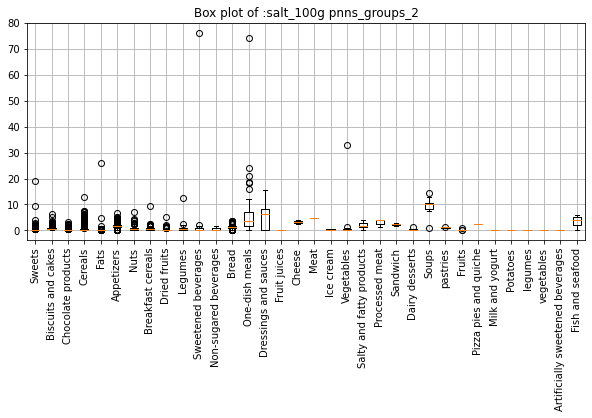

In [13]:
for j in quantitative_features:
    x = [data_pnns.loc[data_pnns['pnns_groups_2']== i, j] for i in data_pnns['pnns_groups_2'].unique()]
    fig = plt.figure(figsize=(10,4))
    plt.boxplot(x, widths=0.5,)
    plt.xticks(list(range(1,len(data_pnns['pnns_groups_2'].unique())+1)),list(data_pnns['pnns_groups_2'].unique()), rotation = 90)
    plt.title('Box plot of :'+j+' pnns_groups_2')
    plt.grid()
    plt.show()

## 6. Bivariante analysis

### 6.1 Category features

#### 6.1.1 Distribution of pnns groups 1 & 2

C:\Users\emanu\AppData\Local\Temp\ipykernel_5784\591524750.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pnns_data = pnns_data.append({'code': others, 'index' : 'Others'}, ignore_index=True)


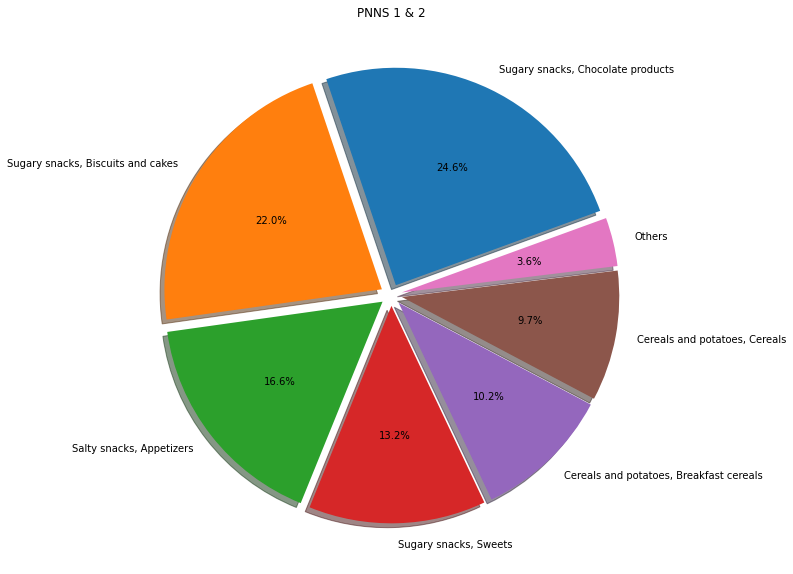

In [14]:
pnns_data = pd.DataFrame(data.groupby(['pnns_groups_1','pnns_groups_2']).count()['code']).sort_values(by = ['code'], ascending = False)
pnns_data['index'] = [str(i[0]) +', '+str(i[1]) for i in pnns_data.index]
pnns_data.loc[pnns_data['code']>100]
others = pnns_data.loc[pnns_data['code']<100,'code'].sum()
pnns_data = pnns_data.loc[pnns_data['code']>=750]
pnns_data = pnns_data.append({'code': others, 'index' : 'Others'}, ignore_index=True)
pnns_data

labels = pnns_data['index']
sizes = pnns_data['code']
explode = [0.05 for i in sizes]

fig = plt.figure(figsize=(10,10))
plt.title('PNNS 1 & 2')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=20)
plt.show()


### 6.2 Numerical features

#### 6.2.1 Correlations

energy_100g  fat_100g  saturated-fat_100g  \
energy_100g               1.000     0.901               0.529   
fat_100g                  0.901     1.000               0.559   
saturated-fat_100g        0.529     0.559               1.000   
cholesterol_100g          0.078     0.076               0.206   
carbohydrates_100g       -0.656    -0.850              -0.400   
sugars_100g              -0.157    -0.268               0.111   
fiber_100g               -0.056     0.022              -0.104   
proteins_100g             0.050     0.093              -0.121   
salt_100g                -0.351    -0.123              -0.074   

                    cholesterol_100g  carbohydrates_100g  sugars_100g  \
energy_100g                    0.078              -0.656       -0.157   
fat_100g                       0.076              -0.850       -0.268   
saturated-fat_100g             0.206              -0.400        0.111   
cholesterol_100g               1.000              -0.073        0.111   
carbohydrates_100g            -0.073               1.000        0.470   
sugars_100g                    0.111               0.470        1.000   
fiber_100g                    -0.013              -0.237       -0.303   
proteins_100g                 -0.005              -0.439       -0.438   
salt_100g                     -0.003              -0.201       -0.114   

                    fiber_100g  proteins_100g  salt_100g  
energy_100g             -0.056          0.050     -0.351  
fat_100g                 0.022          0.093     -0.123  
saturated-fat_100g      -0.104         -0.121     -0.074  
cholesterol_100g        -0.013         -0.005     -0.003  
carbohydrates_100g      -0.237         -0.439     -0.201  
sugars_100g             -0.303         -0.438     -0.114  
fiber_100g               1.000          0.364     -0.056  
proteins_100g            0.364          1.000     -0.054  
salt_100g               -0.056         -0.054      1.000

<AxesSubplot:>

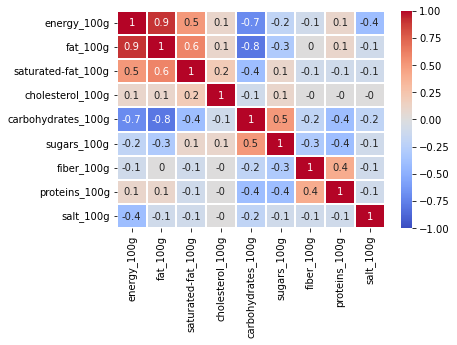

In [15]:
display(round(data.corr(),3))
sns.heatmap(round(data.corr(),1), vmin=-1, vmax=1, linewidths=0.004, center=0, cmap="coolwarm", annot=True)

##### Pnns group 1 correlations

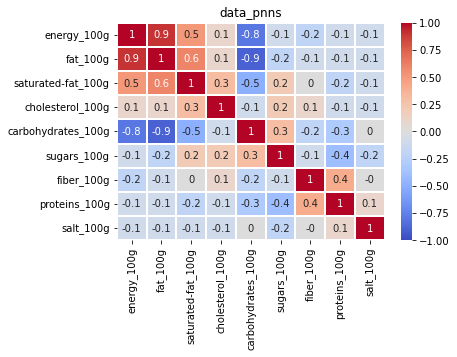

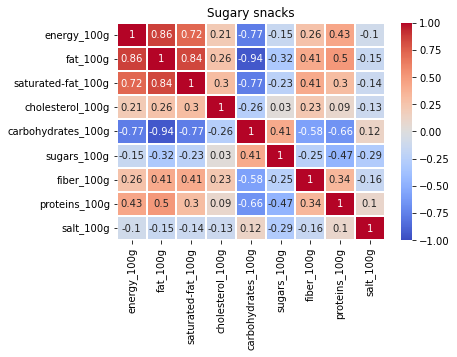

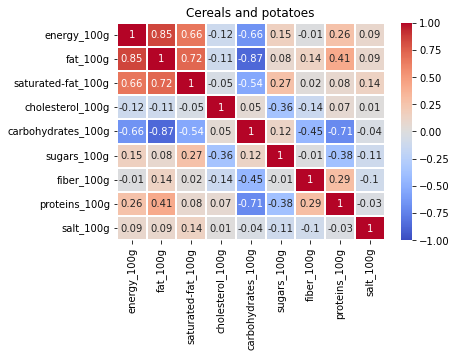

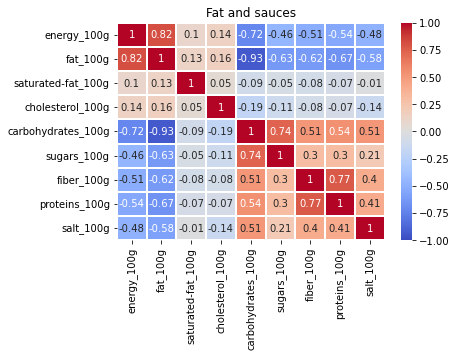

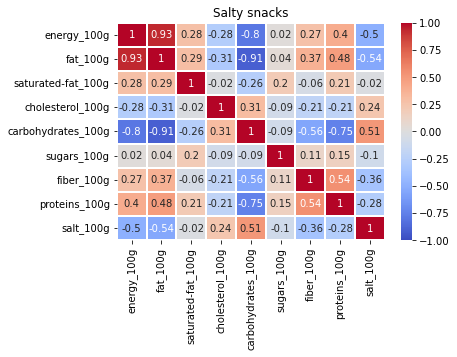

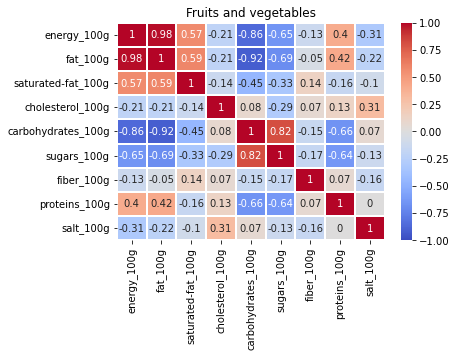

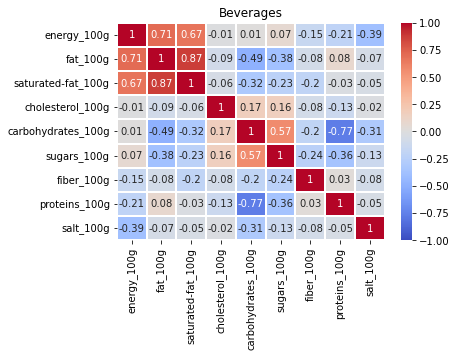

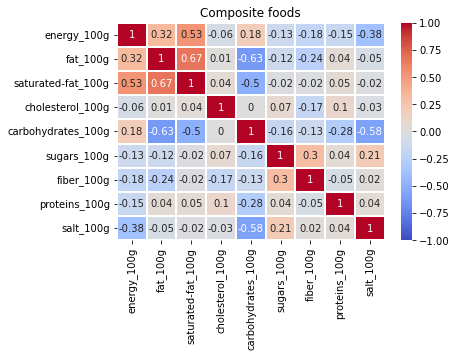

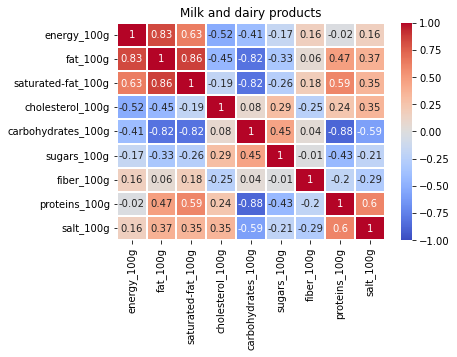

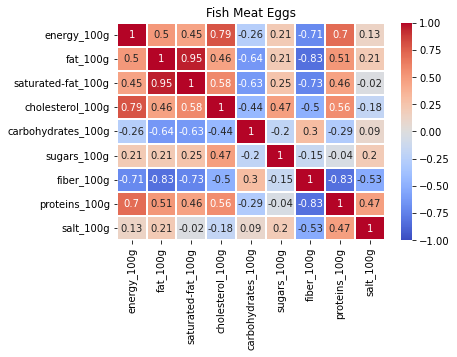

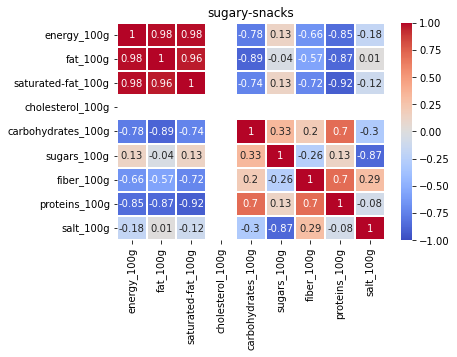

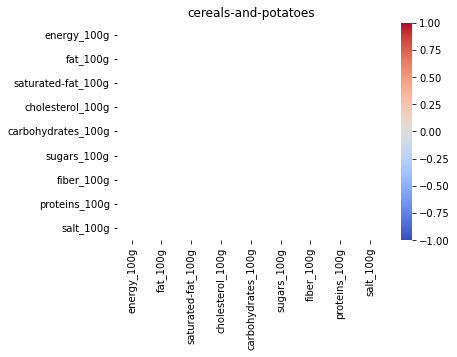

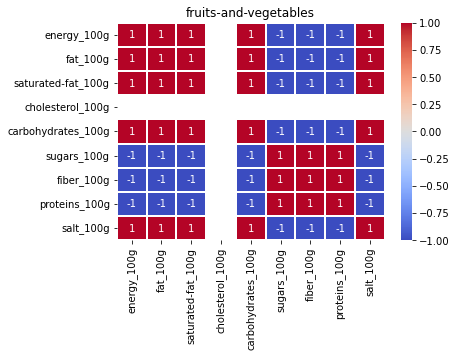

In [36]:
plt.figure()
sns.heatmap(round(data_pnns.corr(),1), vmin=-1, vmax=1, linewidths=0.004, center=0, cmap="coolwarm", annot=True)
plt.title('data_pnns')
plt.show()
plt.close()


for i in data_pnns['pnns_groups_1'].unique():
# display(round(data_pnns.corr(),3))
    plt.figure()
    sns.heatmap(round(data.loc[data['pnns_groups_1']==i].corr(),2), vmin=-1, vmax=1, linewidths=0.004, center=0, cmap="coolwarm", annot=True)
    plt.title(i)
    plt.show()
    plt.close()

#### 6.2.2 Distribution

60.40625
Running time: 51.86 min


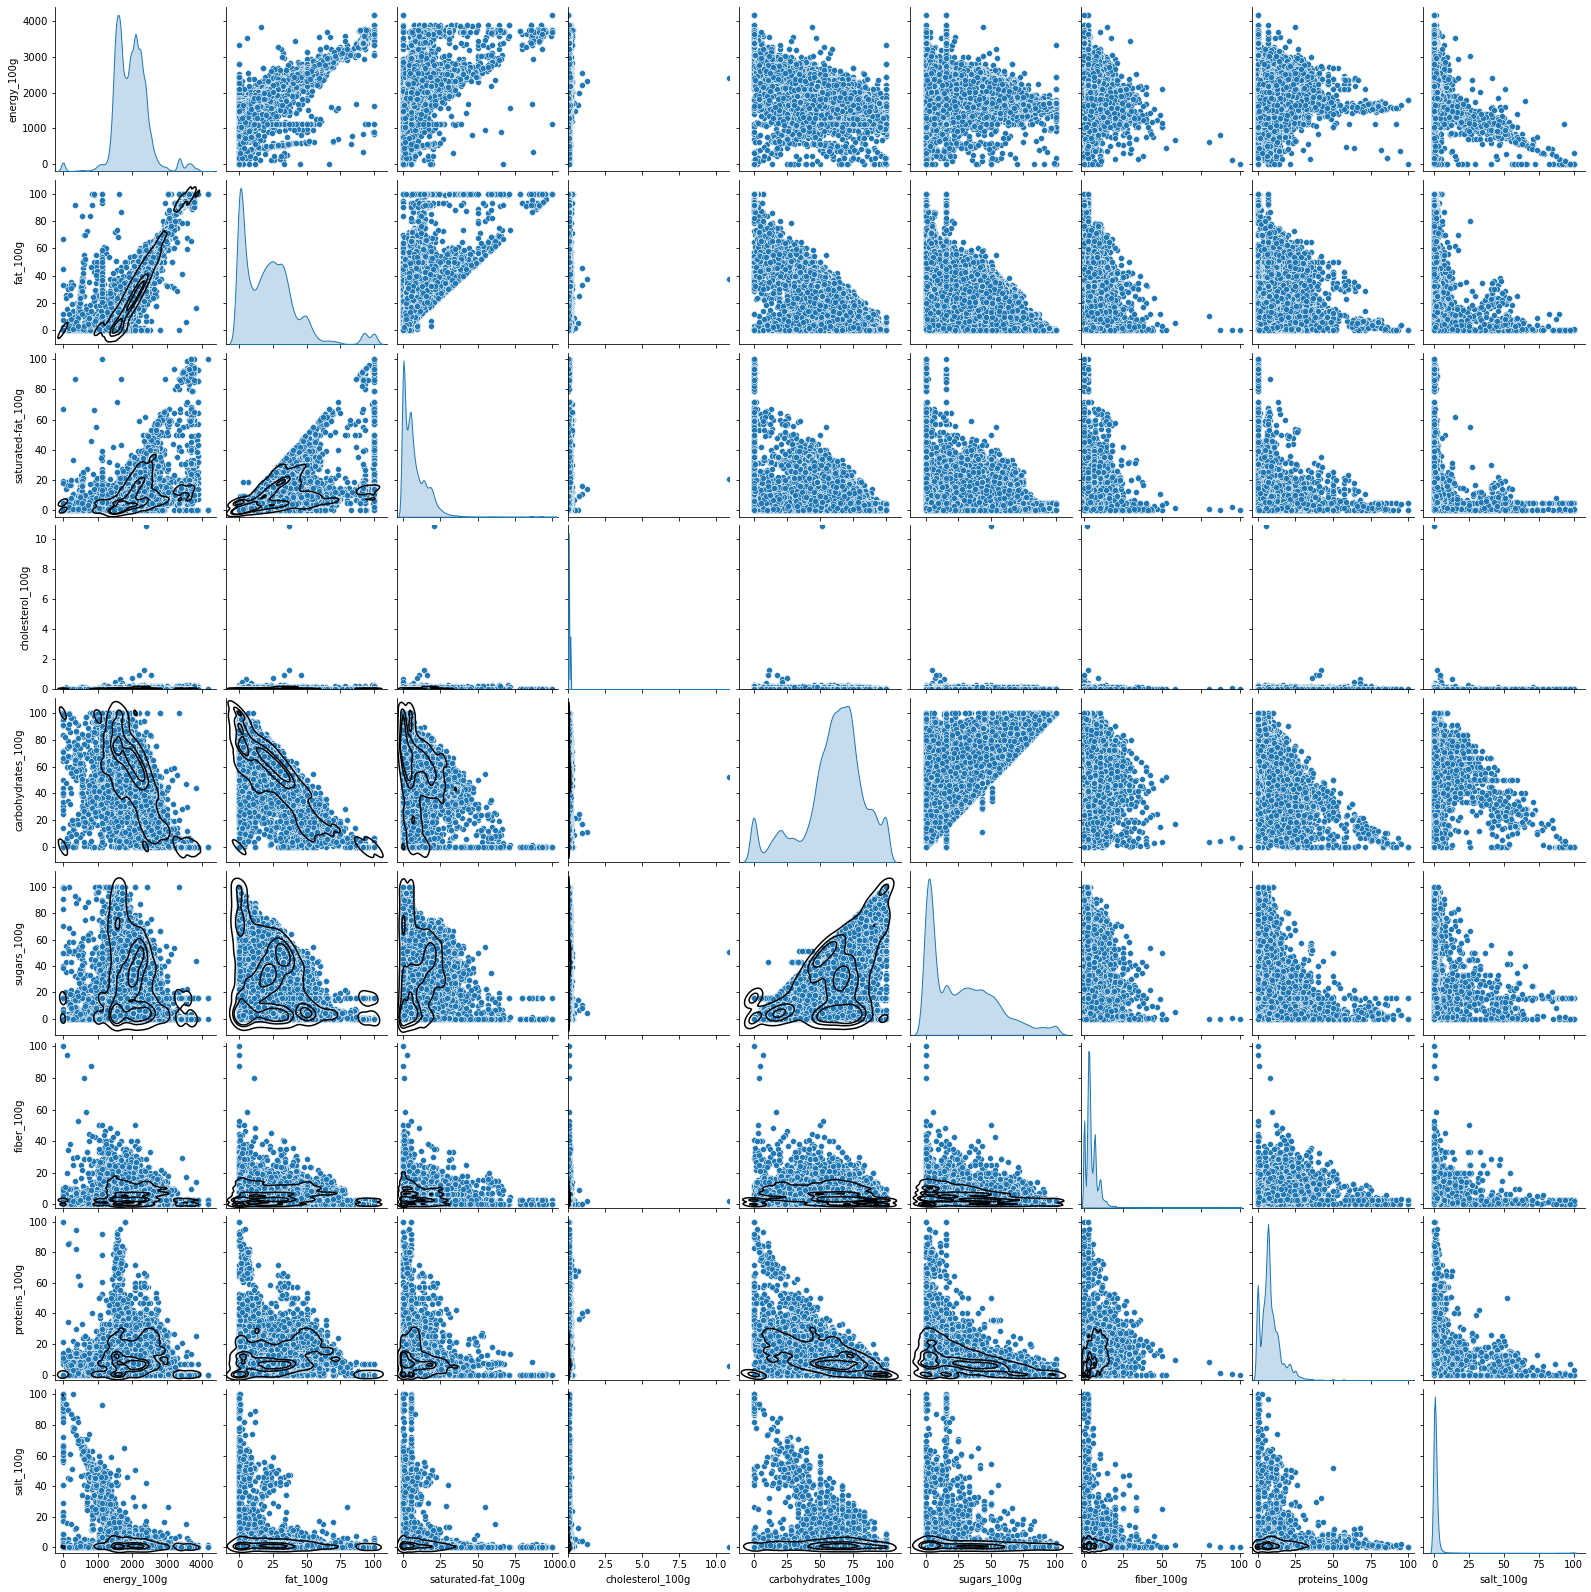

In [16]:
tic = time.process_time()
print(tic)
g = sns.pairplot(data[quantitative_features], diag_kind="kde", corner=False)
g.map_lower(sns.kdeplot, levels=4, color="0")
toc= time.process_time()
print('Running time: '+str(round((toc-tic)/(60),2))+' min')

## 7. Multivariate analysis

### 7.1 PCA

In [18]:
n1 = len(data['pnns_groups_1'].drop_duplicates().tolist())
n2 = len(data['pnns_groups_2'].drop_duplicates().tolist())


X = data[quantitative_features].values
names= data[quantitative_features].index

n_comp= len(quantitative_features)

# centering-scaled
X = X.astype(np.float64)
std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)

# Calculation of principal components
pca = decomposition.PCA(n_components= n_comp)
X_projected = pca.fit_transform(X_scaled)


# display
pd.DataFrame(X_projected, index=data[quantitative_features].index, columns=["F"+str(i+1) for i in range(n_comp)])

F1        F2        F3        F4        F5        F6        F7  \
0      1.091923  1.316683  0.169910 -0.063869 -0.555947  0.052697 -1.776995   
1     -0.077781 -1.421777 -0.598968  0.045816  0.304631 -0.306275  0.323610   
2      2.796367 -1.178891 -0.087556 -0.038879  0.414212  0.065572  0.798165   
3     -1.260756 -0.624263 -0.118255  0.325348  0.046476  0.282731 -0.630586   
4     -0.074952 -1.174806 -0.358038  0.323211  0.101723  0.271971  0.071361   
...         ...       ...       ...       ...       ...       ...       ...   
61935  1.170025  1.221534  0.345917  2.419447 -0.201496  0.182247 -0.022639   
61936  3.637238 -0.842768 -0.031816 -0.267142  1.513432 -0.978671  1.366415   
61937 -1.864309 -0.507375 -0.240393 -0.394214  0.163985  1.275491 -0.741375   
61938 -1.038381 -1.375650 -0.417356 -0.047808  0.438212  0.271151 -0.529380   
61939  0.380977 -0.473554  0.118400 -0.451776  0.396580  0.568981 -0.195851   

             F8        F9  
0     -0.279365  0.035251  
1     -0.242168  0.141040  
2      0.219555  0.080257  
3     -0.078629 -0.088423  
4     -0.255339  0.148476  
...         ...       ...  
61935  0.100496 -0.126559  
61936 -0.112954  0.053436  
61937  0.065728 -0.085757  
61938 -0.207824 -0.021934  
61939  0.103796 -0.178323  

[61940 rows x 9 columns]

#### 7.2 Scree plot

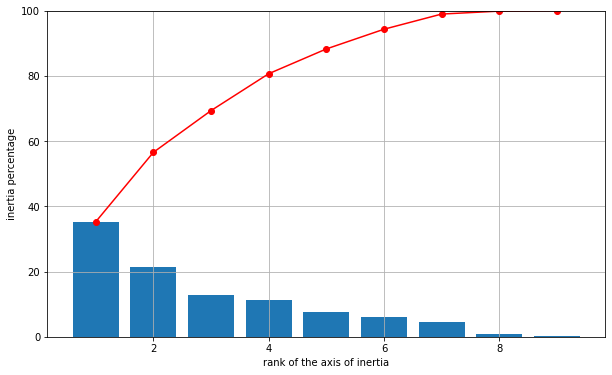

In [19]:
fig = plt.figure(figsize=(10,6))
screes = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(screes))+1, screes)
plt.plot(np.arange(len(screes))+1, screes.cumsum(),c="red",marker='o')
plt.ylim(0,100)
plt.xlabel("rank of the axis of inertia")
plt.ylabel("inertia percentage")
plt.grid()
plt.show()

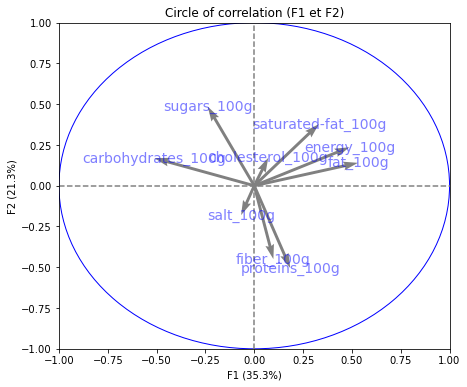

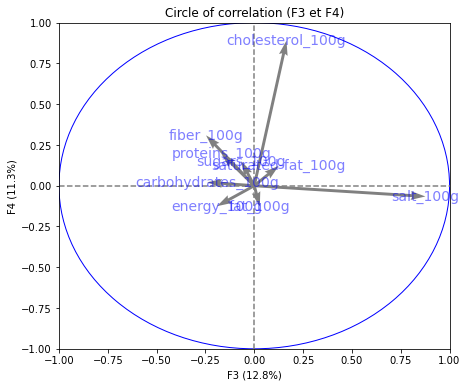

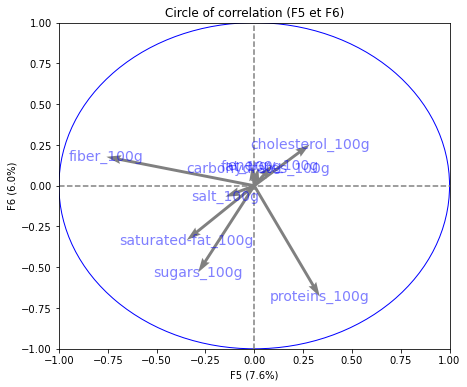

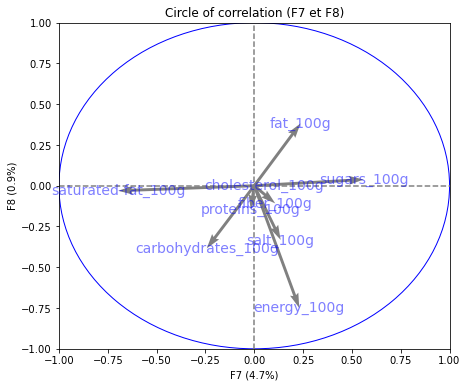

In [20]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5),(6,7)],labels=np.array(quantitative_features))

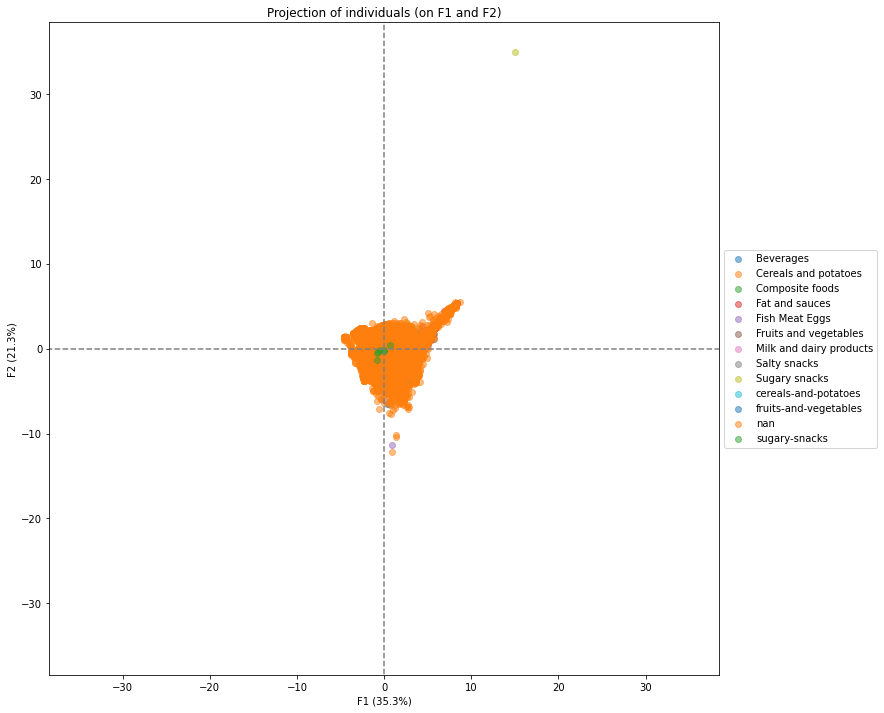

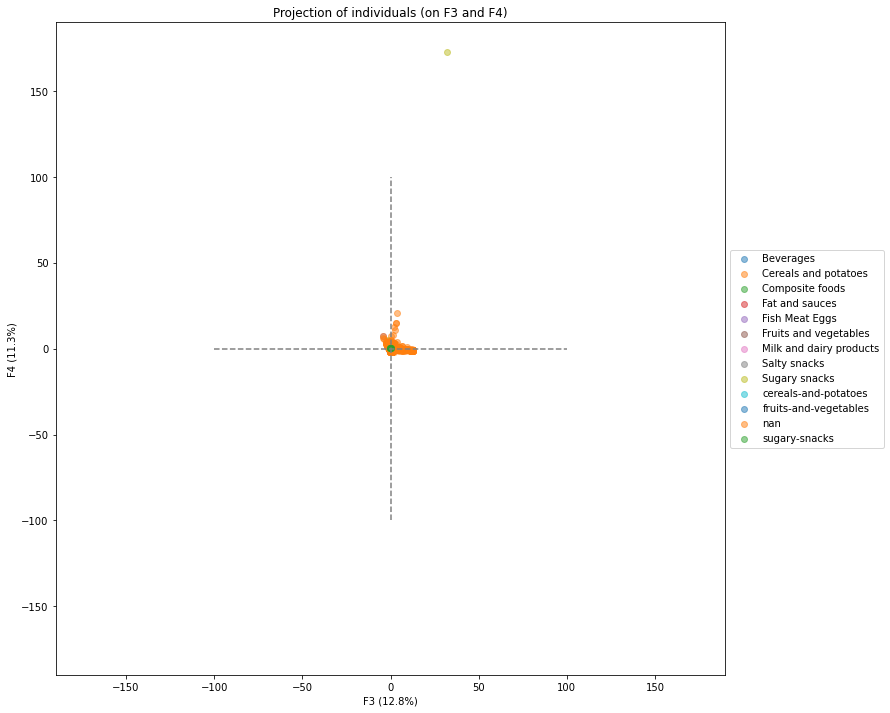

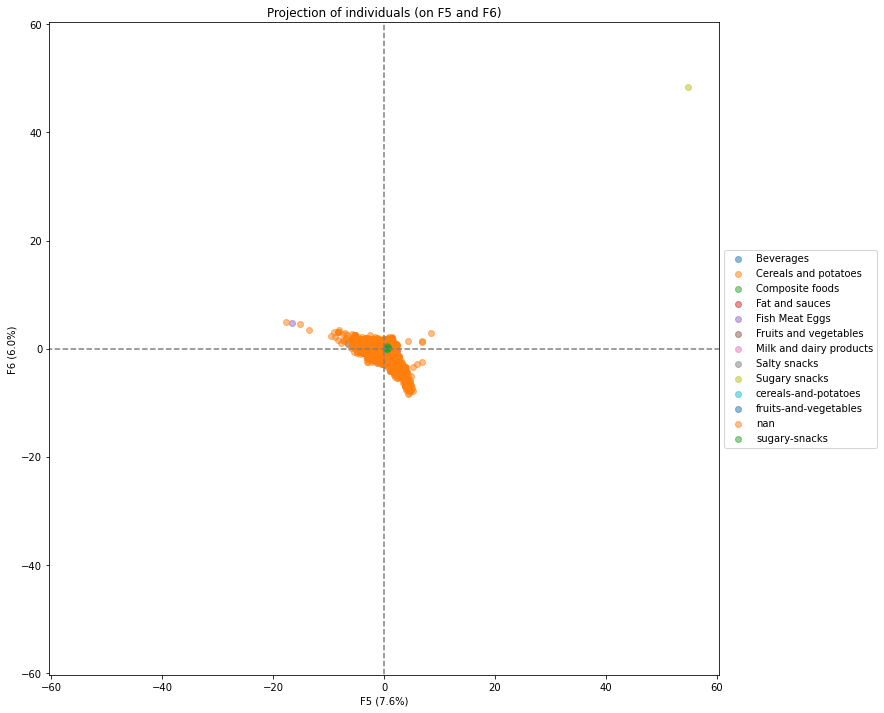

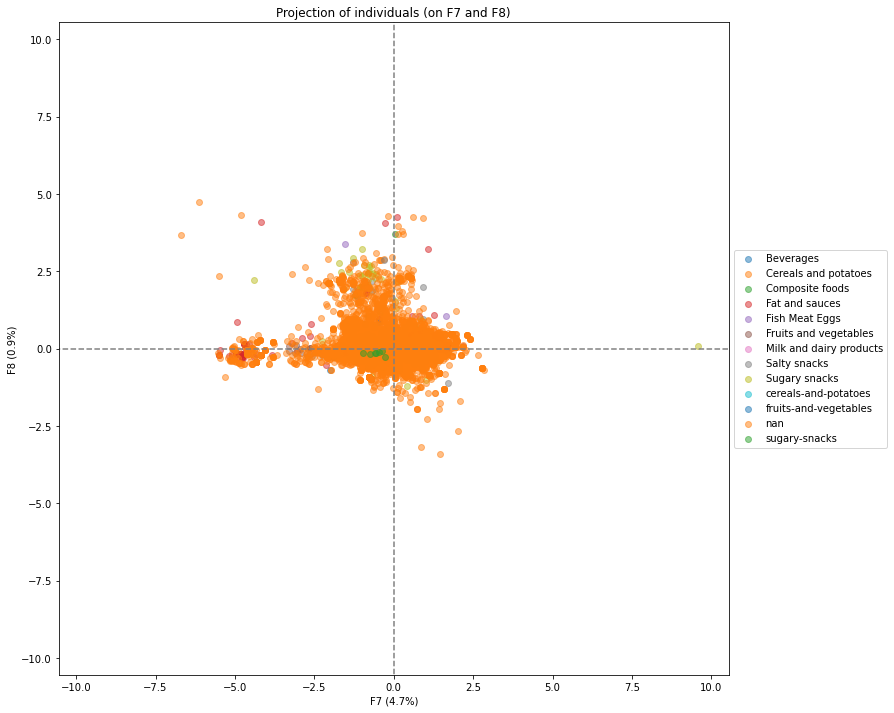

In [21]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5),(6,7)], alpha = 0.5, illustrative_var=[data.loc[x,'pnns_groups_1'] for x in data.index])

plt.show()

### 7.2 ANOVA

In [22]:
"""
The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent.

2. Each sample is from a normally distributed population.

3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
"""
anova_multi_dic={}
for i in data_pnns['pnns_groups_1'].unique():
    x = [data_pnns.loc[data_pnns['pnns_groups_1']== i, j] for j in quantitative_features]
    f, p = f_oneway(*x)
    anova_multi_dic[str(i)]=f,p
    print('\n'+str(i))
    print('F statistic: '+str(f))
    print('p-value: '+str(p))


Sugary snacks
F statistic: 323149.272582432
p-value: 0.0

Cereals and potatoes
F statistic: 117268.78601701514
p-value: 0.0

Fat and sauces
F statistic: 40263.527242384145
p-value: 0.0

Salty snacks
F statistic: 130254.76765825173
p-value: 0.0

Fruits and vegetables
F statistic: 1726.6821965373003
p-value: 0.0

Beverages
F statistic: 3143.3969935015484
p-value: 0.0

Composite foods
F statistic: 2578.05469325712
p-value: 0.0

Milk and dairy products
F statistic: 419.57997702500666
p-value: 8.846663581521469e-73

Fish Meat Eggs
F statistic: 16.91325880525128
p-value: 3.025896217646537e-12

sugary-snacks
F statistic: 1121.6701360039815
p-value: 3.762518091530216e-57

cereals-and-potatoes
F statistic: nan
p-value: nan

fruits-and-vegetables
F statistic: 154.29647495127332
p-value: 1.0252631594252373e-08


C:\Users\emanu\anaconda3\lib\site-packages\scipy\stats\stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


In [23]:
anova_multiv_dataframe = pd.DataFrame.from_dict(anova_multi_dic, orient='index', columns=['F_statistics','p-values']).sort_values('p-values', ascending=False)
# anova_multiv_dataframe.loc[anova_multiv_dataframe['p-values']>0]
anova_multiv_dataframe


F_statistics      p-values
fruits-and-vegetables       154.296475  1.025263e-08
Fish Meat Eggs               16.913259  3.025896e-12
sugary-snacks              1121.670136  3.762518e-57
Milk and dairy products     419.579977  8.846664e-73
Sugary snacks            323149.272582  0.000000e+00
Cereals and potatoes     117268.786017  0.000000e+00
Fat and sauces            40263.527242  0.000000e+00
Salty snacks             130254.767658  0.000000e+00
Fruits and vegetables      1726.682197  0.000000e+00
Beverages                  3143.396994  0.000000e+00
Composite foods            2578.054693  0.000000e+00
cereals-and-potatoes               NaN           NaN